### load funcs and packages

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import scipy
from sklearn.decomposition import PCA
import os
import sys
from scipy.stats import pearsonr
os.chdir('/projects/sccn/weili_A1/liacz/Documents/Bilingualism_CVAE')
sys.path.append('/projects/sccn/weili_A1/liacz/Documents/Bilingualism_CVAE/misc')
from helper_funcs import *
import statsmodels.api as sm
import seaborn as sns


In [2]:
def data2cmat(data):
    return np.array([squareform(pdist(data[s,:,:],metric='euclidean')) for s in range(data.shape[0])])

# Bar plot function
def plot_nice_bar(key,rsa,ax=None,figsize=None,dpi=None,fontsize=None,fontsize_star=None,fontweight=None,line_width=None,marker_size=None,title=None,report_t=False,do_pairwise_stars=False,do_one_sample_stars=True):
    
    import seaborn as sns
    from scipy.stats import ttest_1samp
    from scipy.stats import ttest_ind as ttest
    
    pallete = sns.color_palette()
    pallete_new = sns.color_palette()
    
    if not figsize:
        figsize = (5,2)
    if not dpi:
        dpi = 300
        
    if not ax:
        fig, ax = plt.subplots(1,1,figsize=figsize,dpi=dpi)

    pallete_new[1]=pallete[0]
    pallete_new[0]=pallete[1]
    pallete_new[0] = tuple(np.array((.5,.5,.5)))

    data=rsa[key]
    n = data.shape[0]
    c = data.shape[1]
    x = np.arange(c)
    
    if not fontsize:
        fontsize = 16
        
    if not fontsize_star:
        fontsize_star = 25
    if not fontweight:        
        fontweight = 'bold'
    if not line_width:    
        line_width = 2.5
    if not marker_size:            
        marker_size = .1
    


    for i in range(c):
        plot_data = np.zeros(data.shape)
        plot_data[:,i] = data[:,i]

        xs = np.repeat(i,n)+(np.random.rand(n)-.5)*.25
        sc = plt.scatter(xs,data[:,i],c='k',s = marker_size)
        b = sns.barplot(data=plot_data,errcolor='r',linewidth=line_width,errwidth=line_width,facecolor=np.hstack((np.array(pallete_new[i]),.3)),edgecolor=np.hstack((np.array(pallete_new[i]),1)))

    locs, labels = plt.yticks()  
    new_y = locs
    new_y = np.linspace(locs[0],locs[-1],6)
    plt.yticks(new_y,labels=[f'{yy:.2f}' for yy in new_y],fontsize=fontsize,fontweight=fontweight)
    plt.ylabel('model fit (r)',fontsize=fontsize,fontweight=fontweight)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)

    for axis in ['top','bottom','left','right']:
            ax.spines[axis].set_linewidth(line_width)

    xlbls = ['VAE','BG','SL']
    plt.xticks(np.arange(3),labels=xlbls,fontsize=fontsize,fontweight=fontweight)
    
    if do_one_sample_stars:
        one_sample = np.array([ttest_1samp(data[:,i],0) for i in range(3)])
        one_sample_thresh = np.array((1,.05,.001,.0001))
        one_sample_stars = np.array(('n.s.','*','**','***'))
        xlbls = ['VAE','BG','SL']
        for i in range(c):
            these_stars = one_sample_stars[max(np.nonzero(one_sample[i,1]<one_sample_thresh)[0])]
            xlbls[i] = f'{xlbls[i]}\n({these_stars})'
        plt.xticks(np.arange(3),labels=xlbls,fontsize=fontsize,fontweight=fontweight,horizontalalignment='center',multialignment='center')

    pairwise_t = np.zeros((3,3))
    pairwise_p = np.zeros((3,3))

    pairwise_sample_thresh = np.array((1,.05,.001,.0001))
    pairwise_sample_stars = np.array(('n.s.','*','**','***'))

    if report_t:
        for i in range(c):
            for j in range(c):
                t,p = ttest(data[:,i],data[:,j])
                mnames = ['VAE','BG','SL']

                if p > .001:
                    print(f'{key} {mnames[i]} >  {mnames[j]} | t({data.shape[0]-1}) = {t:.2f} p = {p:.2f}')
                else:
                    print(f'{key} {mnames[i]} >  {mnames[j]} | t({data.shape[0]-1}) = {t:.2f} p $<$ .001')
                pairwise_t[i,j] = t
                pairwise_p[i,j] = p

    comps = [[1,2]]
    if do_pairwise_stars:
        for comp_idx in range(len(comps)):
            this_comp = comps[comp_idx]
            sig_idx = max(np.nonzero(pairwise_p[this_comp[0],this_comp[1]]<pairwise_sample_thresh)[0])
            max_y = new_y[-1] + comp_idx*.05
            xs = np.array(this_comp)
            stars = pairwise_sample_stars[sig_idx]
            plt.plot(xs,[max_y,max_y],'k',linewidth=line_width)
            plt.text(xs.mean(),max_y,stars,fontsize=fontsize_star,horizontalalignment='center',fontweight=fontweight)
        
#     ylim = plt.ylim()
#     plt.ylim(np.array(ylim)*(1,1.1))
    plt.ylim(-0.1, 0.16)
    plt.yticks([-0.1,-0.05, 0, 0.05, 0.1, 0.15], ['-0.1','-0.05', '0', '0.05', '0.1', '0.15'])
    
    if not title:
        plt.title(key,fontsize=fontsize*1.5,pad=2,fontweight=fontweight)    
    else:
        plt.title(title,fontsize=fontsize*1.5,pad=2,fontweight=fontweight)

def make_RDM(inVec, data_scale='ratio', metric='euclidean'):
    vec = inVec
    def fun(u,v):
        const = 0 if u[0] == v[0] else 1
        return np.sqrt(const**2)
    if data_scale=='ratio':
        vec = (vec - min(vec.flatten())) / (max(vec.flatten())-min(vec.flatten()))
    
    if np.ndim(inVec)==1: # must be at least 2D
        vec = np.vstack((vec,np.zeros(vec.shape))).transpose()
    if data_scale=='ordinal':
        mat = squareform(pdist(vec, fun).transpose())
#         mat[mat!=0]=1 # Make into zeros and ones
    if data_scale=='ratio':
        mat = squareform(pdist(vec,metric=metric).transpose())
    return mat

def slice_cmat(data,idx):
#     mat = data[patients,:][:,patients]
    mat = data[idx,:][:,idx]
    return mat

def fit_rsa(data, key, model_rdms, model_idxs):
    corr = scipy.stats.stats.kendalltau
    r = np.array([corr(get_triu(slice_cmat(data[i,:,:],model_idxs[key])),get_triu(model_rdms[key]))[0] for i in range(10)])
    r = np.arctan(r)
    return r

### get the latent vectors

In [6]:
exp = '8b2aa1f'

In [7]:
# from datetime import datetime
# print(datetime.fromtimestamp(os.path.getmtime('data/tf_outputs/CVAE')))

In [8]:
salient_vec_BRAIN = np.load(f'data/latent_vecs/{exp}/latent_vecs10_s.npz')['salient_vec_BRAIN']
background_vec_BRAIN = np.load(f'data/latent_vecs/{exp}/latent_vecs10_z.npz')['background_vec_BRAIN']
vae_vec_BRAIN = np.load(f'data/latent_vecs/{exp}/latent_vecs10_vae.npz')['vae_vec_BRAIN']
print(len(salient_vec_BRAIN))
print(len(background_vec_BRAIN))
print(len(vae_vec_BRAIN))

10
10
10


In [9]:
print(salient_vec_BRAIN.shape)
print(background_vec_BRAIN.shape)
print(vae_vec_BRAIN.shape)

(10, 1655, 16)
(10, 1655, 16)
(10, 1655, 32)


In [10]:
# Make (dis)similarity matrices
cmat_salient_vec_BRAIN = data2cmat(salient_vec_BRAIN)
cmat_background_vec_BRAIN = data2cmat(background_vec_BRAIN)
cmat_vae_vec_BRAIN = data2cmat(vae_vec_BRAIN)

### get Hernandez data

In [11]:
df = pd.read_csv(os.path.expanduser('data/legend/Hernandez.csv'))
len(df)

363

In [12]:
df['scanner'].value_counts()

scanner
MagnetomTrio    363
Name: count, dtype: int64

In [13]:
indir = 'data/array_brains'
BRAIN_data = np.load(os.path.join(indir, f"arr_combine/{exp}/BRAIN_data.npy"))
BRAIN_subs = np.load(os.path.join(indir, f"arr_combine/{exp}/BRAIN_subs.npy"))
BRAIN_ds = np.load(os.path.join(indir, f"arr_combine/{exp}/BRAIN_ds.npy"))
legend_subs= df['ds_par_id']
BRAIN_ds_subs = [BRAIN_ds[i]+'_'+BRAIN_subs[i] for i in range(0,len(BRAIN_subs))]

BRAIN_subs.shape

(1655,)

In [14]:
BRAIN_ds_subs_pd = pd.DataFrame(BRAIN_ds_subs, columns = ['ds_par_id'])
BRAIN_ds_subs_pd['index'] = range(len(BRAIN_ds_subs_pd.iloc[:,0]))
BRAIN_ds_subs_pd

,ds_par_id,index
0,Hernandez_WL_052.mgz,0
1,Hernandez_271ES.mgz,1
2,Hernandez_PI_028.mgz,2
3,Hernandez_71_E.mgz,3
4,Hernandez_WL_002.mgz,4
...,...,...
1650,HCPdev_HCD2055237_V1_MR,1650
1651,HCPdev_HCD0232223_V1_MR,1651
1652,HCPdev_HCD0392649_V1_MR,1652
1653,HCPdev_HCD0197348_V1_MR,1653


In [15]:
df_sort = pd.merge(df, BRAIN_ds_subs_pd, how = 'right', on ='ds_par_id').sort_values(by=['index'])
df_sort.drop_duplicates(inplace=True)
#filter rows with NaN in participant_id
df_sort = df_sort[df_sort['participant_id'].notna()]

df_sort['bilingualism']=pd.to_numeric(df_sort.bilingualism)
# df_sort['num_lan']=pd.to_numeric(df_sort.num_lan)
df_sort['age']=pd.to_numeric(df_sort.age)
df_sort['aoa']=pd.to_numeric(df_sort.aoa)
# df_sort['sec_lan_proficiency']=pd.to_numeric(df_sort.sec_lan_proficiency)
# df_sort['sec_lan_exposure']=pd.to_numeric(df_sort.sec_lan_exposure)


In [16]:
df_sort.columns

Index(['participant_id', 'lan_group', 'sex', 'aoa_group', 'aoa', 'age',
       'YearsEnglishEdu', 'YearsSpanishEdu', 'PercentEngPictureVocabulary',
       'PercentEngPassageComprehension', 'PercentSpanPictureVocabulary',
       'PercentSpanPassageComprehension', 'Mom_Edu', 'Dad_Edu', 'SES',
       'BirthPlace', 'StudyName', 'PercentEngListeningComprehension',
       'PercentSpanListeningComprehension', 'BNTEnglish', 'BNTSpanish',
       'DailyE', 'DailyS', 'Eprof', 'Sprof', 'bilingualism', 'ds', 'scanner',
       'ds_par_id', 'index'],
      dtype='object')

### variables relationships

In [17]:
df_sort['bilingualism'].value_counts()

bilingualism
1.0    215
0.0    145
Name: count, dtype: int64

In [18]:
df_sort['DailyE'].isna().sum()

np.int64(2)

In [19]:
df_sort['DailyE'] = pd.to_numeric(df_sort['DailyE'], errors='coerce')
df_sort['DailyS'] = pd.to_numeric(df_sort['DailyS'], errors='coerce')

df_sort['non_dominant_prof'] = df_sort[['Sprof', 'Eprof']].min(axis=1)
df_sort['dominant_prof'] = df_sort[['Sprof', 'Eprof']].max(axis=1)
df_sort['balance_index'] = df_sort['dominant_prof'] - df_sort['non_dominant_prof']
df_sort['use_index'] = abs(df_sort['DailyE'] - df_sort['DailyS'])

/tmp/ipykernel_2423355/1163412505.py:1: FutureWarning: The behavior of DataFrame.idxmax with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  df_sort[['Sprof', 'Eprof']].idxmax(axis=1).value_counts()


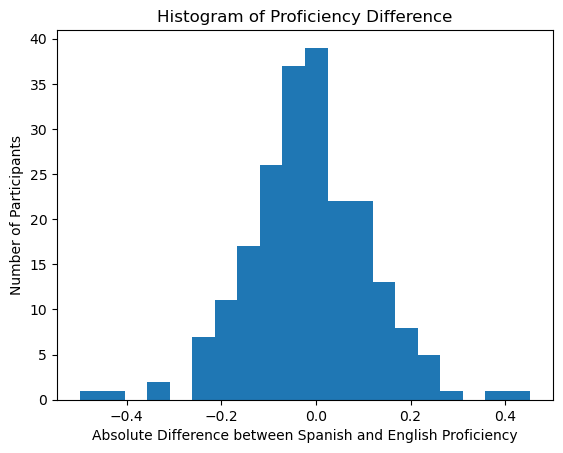

In [25]:
df_sort[['Sprof', 'Eprof']].idxmax(axis=1).value_counts()

##hist of difference between proficiencies
df_sort['prof_diff'] = df_sort['Sprof'] - df_sort['Eprof']
plt.hist(df_sort['prof_diff'], bins=20)
plt.xlabel('Absolute Difference between Spanish and English Proficiency')
plt.ylabel('Number of Participants')
plt.title('Histogram of Proficiency Difference')
plt.show()

In [32]:
df_sort['prof_diff'].std()

np.float64(0.1302994002276944)

In [30]:
df_sort[['Sprof', 'Eprof']].idxmax(axis=1).value_counts()/len(df_sort)

/tmp/ipykernel_2423355/1817456542.py:1: FutureWarning: The behavior of DataFrame.idxmax with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  df_sort[['Sprof', 'Eprof']].idxmax(axis=1).value_counts()/len(df_sort)


Eprof    0.719444
Sprof    0.261111
Name: count, dtype: float64

In [518]:
pred = df_sort[['dominant_prof', 'non_dominant_prof','balance_index', 'aoa', 'age', 'sex', 'SES', 'bilingualism']]
pred['sex'] = df_sort['sex'].astype('category').cat.codes
rho = pred.corr()
pval = pred.corr(method=lambda x, y: pearsonr(x, y)[1]) - np.eye(*rho.shape)
p = pval.applymap(lambda x: ''.join(['*' for t in [.05, .01, .001] if x<=t]))
rho.round(2).astype(str) + p

/tmp/ipykernel_1102596/2401259408.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred['sex'] = df_sort['sex'].astype('category').cat.codes
/tmp/ipykernel_1102596/2401259408.py:4: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  pval = pred.corr(method=lambda x, y: pearsonr(x, y)[1]) - np.eye(*rho.shape)
/tmp/ipykernel_1102596/2401259408.py:5: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  p = pval.applymap(lambda x: ''.join(['*' for t in [.05, .01, .001] if x<=t]))


,dominant_prof,non_dominant_prof,balance_index,aoa,age,sex,SES,bilingualism
dominant_prof,1.0***,0.72***,-0.02,0.13,0.17**,0.02,0.31***,-0.31***
non_dominant_prof,0.72***,1.0***,-0.7***,-0.01,0.07,0.04,0.36***,-0.63***
balance_index,-0.02,-0.7***,1.0***,0.14*,0.07,-0.04,-0.18**,0.59***
aoa,0.13,-0.01,0.14*,1.0***,0.54***,0.18**,0.04,nan
age,0.17**,0.07,0.07,0.54***,1.0***,0.1,-0.09,-0.01
sex,0.02,0.04,-0.04,0.18**,0.1,1.0***,0.07,0.11*
SES,0.31***,0.36***,-0.18**,0.04,-0.09,0.07,1.0***,-0.51***
bilingualism,-0.31***,-0.63***,0.59***,nan,-0.01,0.11*,-0.51***,1.0***


=== DESCRIPTIVE ANALYSIS OF VARIABLES ===
Total bilingual subjects: 215

=== DOMINANT_PROF ===
Valid cases: 215
Missing: 0
Mean: 0.76
Std: 0.08
Median: 0.76
Min: 0.53
Max: 0.96
25th percentile: 0.71
75th percentile: 0.82

=== NON_DOMINANT_PROF ===
Valid cases: 215
Missing: 0
Mean: 0.66
Std: 0.10
Median: 0.67
Min: 0.33
Max: 0.87
25th percentile: 0.60
75th percentile: 0.73

=== BALANCE_INDEX ===
Valid cases: 215
Missing: 0
Mean: 0.10
Std: 0.08
Median: 0.08
Min: 0.00
Max: 0.50
25th percentile: 0.04
75th percentile: 0.14

=== AOA ===
Valid cases: 215
Missing: 0
Mean: 7.50
Std: 5.33
Median: 6.00
Min: 0.00
Max: 27.00
25th percentile: 4.00
75th percentile: 9.00

=== AGE ===
Valid cases: 215
Missing: 0
Mean: 23.17
Std: 4.58
Median: 22.00
Min: 18.00
Max: 40.00
25th percentile: 20.00
75th percentile: 25.00

=== SES ===
Valid cases: 178
Missing: 37
Mean: 2.65
Std: 1.44
Median: 2.50
Min: 1.00
Max: 6.00
25th percentile: 1.50
75th percentile: 3.50

=== SEX (BINARY) ===
Frequency and percentage:
F: 1

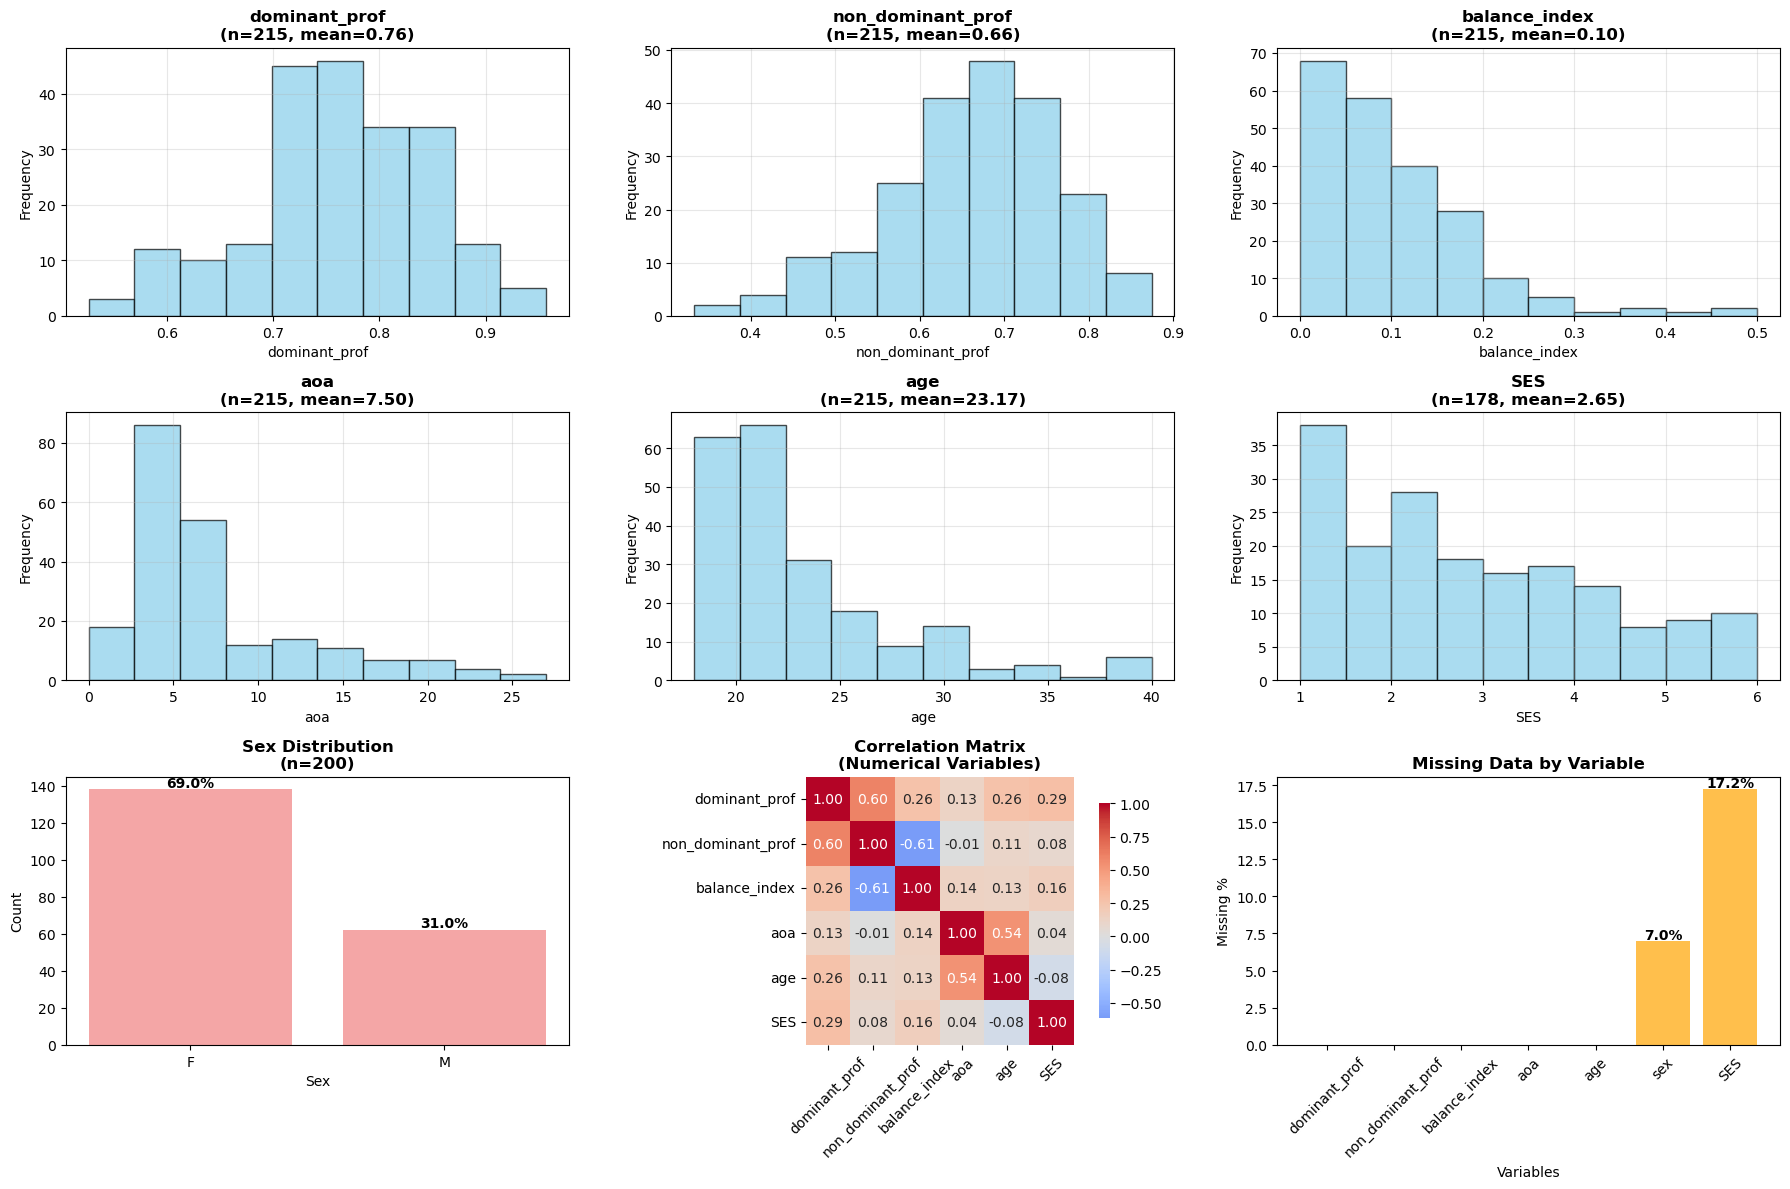

=== SUMMARY TABLE ===
         Variable   N  Missing  Mean   SD   Min   Max Range
    dominant_prof 215        0  0.76 0.08  0.53  0.96  0.43
non_dominant_prof 215        0  0.66 0.10  0.33  0.87  0.54
    balance_index 215        0  0.10 0.08  0.00  0.50  0.50
              aoa 215        0  7.50 5.33  0.00 27.00 27.00
              age 215        0 23.17 4.58 18.00 40.00 22.00
              SES 178       37  2.65 1.44  1.00  6.00  5.00

Sex: N=200, Missing=15
  F: 138 (69.0%)
  M: 62 (31.0%)


In [520]:
# Focus on bilingual subjects for the variables of interest
df_bi = df_sort[df_sort['bilingualism'] == 1]

# Variables of interest
variables = ['dominant_prof', 'non_dominant_prof', 'balance_index', 'aoa', 'age', 'sex', 'SES']

print("=== DESCRIPTIVE ANALYSIS OF VARIABLES ===")
print(f"Total bilingual subjects: {len(df_bi)}")
print()

# Descriptive statistics for numerical variables
numerical_vars = ['dominant_prof', 'non_dominant_prof', 'balance_index', 'aoa', 'age', 'SES']

for var in numerical_vars:
    print(f"=== {var.upper()} ===")
    data = df_bi[var].dropna()
    print(f"Valid cases: {len(data)}")
    print(f"Missing: {df_bi[var].isna().sum()}")
    if len(data) > 0:
        print(f"Mean: {data.mean():.2f}")
        print(f"Std: {data.std():.2f}")
        print(f"Median: {data.median():.2f}")
        print(f"Min: {data.min():.2f}")
        print(f"Max: {data.max():.2f}")
        print(f"25th percentile: {data.quantile(0.25):.2f}")
        print(f"75th percentile: {data.quantile(0.75):.2f}")
    print()

# Sex (binary variable)
print("=== SEX (BINARY) ===")
sex_counts = df_bi['sex'].value_counts(dropna=False)
sex_props = df_bi['sex'].value_counts(normalize=True, dropna=False) * 100

print("Frequency and percentage:")
for category in sex_counts.index:
    if pd.isna(category):
        print(f"Missing: {sex_counts[category]} ({sex_props[category]:.1f}%)")
    else:
        print(f"{category}: {sex_counts[category]} ({sex_props[category]:.1f}%)")
print()

# Visualizations
plt.figure(figsize=(18, 12))

# Histograms for numerical variables
for i, var in enumerate(numerical_vars):
    plt.subplot(3, 3, i+1)
    data = df_bi[var].dropna()
    if len(data) > 0:
        plt.hist(data, bins=10, alpha=0.7, edgecolor='black', color='skyblue')
        plt.title(f'{var}\n(n={len(data)}, mean={data.mean():.2f})', fontweight='bold')
        plt.xlabel(var)
        plt.ylabel('Frequency')
        plt.grid(True, alpha=0.3)

# Bar plot for sex
plt.subplot(3, 3, 7)
sex_clean = df_bi['sex'].dropna()
if len(sex_clean) > 0:
    sex_counts_clean = sex_clean.value_counts()
    plt.bar(sex_counts_clean.index, sex_counts_clean.values, alpha=0.7, color='lightcoral')
    plt.title(f'Sex Distribution\n(n={len(sex_clean)})', fontweight='bold')
    plt.xlabel('Sex')
    plt.ylabel('Count')
    # Add percentage labels on bars
    for i, (category, count) in enumerate(sex_counts_clean.items()):
        pct = count / len(sex_clean) * 100
        plt.text(i, count + max(sex_counts_clean.values) * 0.01, f'{pct:.1f}%', 
                ha='center', fontweight='bold')

# Correlation matrix (excluding sex for now)
plt.subplot(3, 3, 8)
corr_vars = ['dominant_prof', 'non_dominant_prof', 'balance_index', 'aoa', 'age', 'SES']
corr_data = df_bi[corr_vars].corr()

import seaborn as sns
sns.heatmap(corr_data, annot=True, cmap='coolwarm', center=0, 
            square=True, fmt='.2f', cbar_kws={'shrink': 0.8})
plt.title('Correlation Matrix\n(Numerical Variables)', fontweight='bold')
plt.xticks(rotation=45)
plt.yticks(rotation=0)

# Missing data pattern
plt.subplot(3, 3, 9)
missing_counts = df_bi[variables].isnull().sum()
missing_pcts = (missing_counts / len(df_bi)) * 100

bars = plt.bar(range(len(variables)), missing_pcts.values, alpha=0.7, color='orange')
plt.title('Missing Data by Variable', fontweight='bold')
plt.xlabel('Variables')
plt.ylabel('Missing %')
plt.xticks(range(len(variables)), variables, rotation=45)

# Add percentage labels on bars
for i, (var, pct) in enumerate(zip(variables, missing_pcts.values)):
    if pct > 0:
        plt.text(i, pct + max(missing_pcts.values) * 0.01, f'{pct:.1f}%', 
                ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

# Summary table
print("=== SUMMARY TABLE ===")
summary_stats = []
for var in numerical_vars:
    data = df_bi[var].dropna()
    if len(data) > 0:
        summary_stats.append({
            'Variable': var,
            'N': len(data),
            'Missing': df_bi[var].isna().sum(),
            'Mean': f"{data.mean():.2f}",
            'SD': f"{data.std():.2f}",
            'Min': f"{data.min():.2f}",
            'Max': f"{data.max():.2f}",
            'Range': f"{data.max() - data.min():.2f}"
        })

summary_df = pd.DataFrame(summary_stats)
print(summary_df.to_string(index=False))

# Add sex summary
sex_clean = df_bi['sex'].dropna()
if len(sex_clean) > 0:
    print(f"\nSex: N={len(sex_clean)}, Missing={df_bi['sex'].isna().sum()}")
    for category, count in sex_clean.value_counts().items():
        pct = count / len(sex_clean) * 100
        print(f"  {category}: {count} ({pct:.1f}%)")

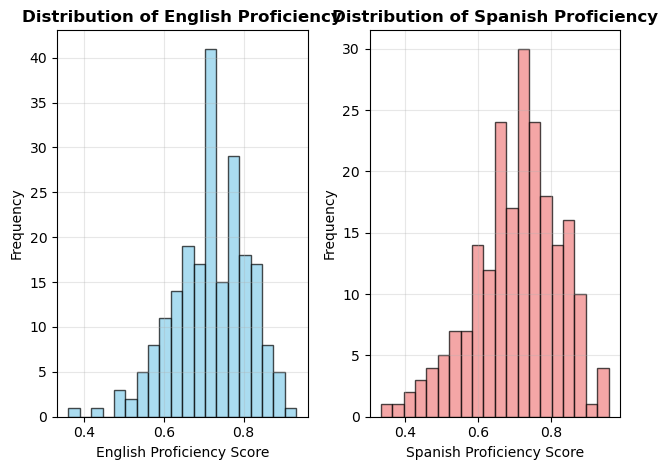


=== BY BILINGUALISM STATUS ===

Monolinguals (n=145):
  Eprof: mean=0.81, std=0.08
  Sprof: No data (all NaN)

Bilinguals (n=215):
  Eprof: mean=0.72, std=0.09
  Sprof: mean=0.71, std=0.12


In [521]:
# English proficiency
plt.subplot(1, 2, 1)
df_sort[df_sort.bilingualism == 1]['Eprof'].hist(bins=20, alpha=0.7, color='skyblue', edgecolor='black')
plt.title('Distribution of English Proficiency', fontweight='bold')
plt.xlabel('English Proficiency Score')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)

# Spanish proficiency
plt.subplot(1, 2, 2)
df_sort[df_sort.bilingualism == 1]['Sprof'].dropna().hist(bins=20, alpha=0.7, color='lightcoral', edgecolor='black')
plt.title('Distribution of Spanish Proficiency', fontweight='bold')
plt.xlabel('Spanish Proficiency Score')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Compare by bilingualism status
print("\n=== BY BILINGUALISM STATUS ===")
for status in [0, 1]:
    label = "Monolinguals" if status == 0 else "Bilinguals"
    subset = df_sort[df_sort['bilingualism'] == status]
    print(f"\n{label} (n={len(subset)}):")
    print(f"  Eprof: mean={subset['Eprof'].mean():.2f}, std={subset['Eprof'].std():.2f}")
    if not subset['Sprof'].isna().all():
        print(f"  Sprof: mean={subset['Sprof'].mean():.2f}, std={subset['Sprof'].std():.2f}")
    else:
        print(f"  Sprof: No data (all NaN)")

#### why not Eprof

Original distributions:
Eprof bins: [ 1  1  4 13 25 36 56 47 25  6]
Sprof bins: [ 2  5  9 14 26 41 54 32 26  5]

Resampled dataset: 214 subjects
Original bilinguals: 214 subjects


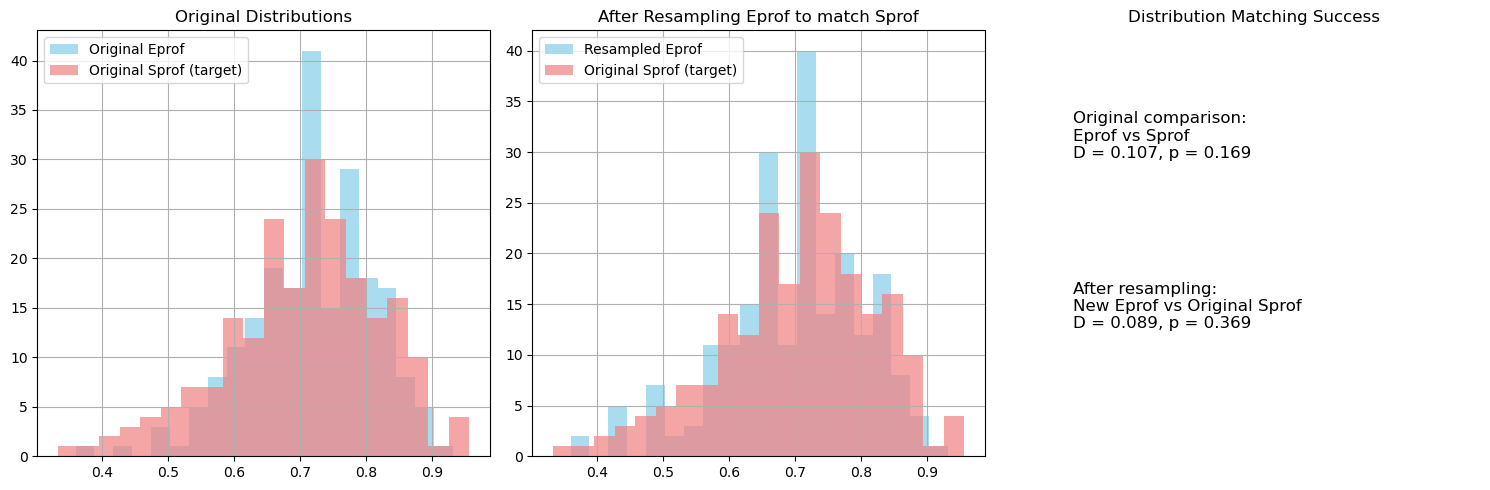


Distribution matching:
Original Eprof vs Sprof: D=0.107, p=0.169
New Eprof vs Original Sprof: D=0.089, p=0.369

Final distributions:
Target Sprof bins: [ 2  5  9 14 26 41 54 32 26  5]
New Eprof bins:    [ 2  5  9 14 26 41 54 32 26  5]


In [341]:
# Get bilinguals with both proficiency scores
df_bi_clean = df_sort[(df_sort['bilingualism'] == 1) & 
                      df_sort['Eprof'].notna() & 
                      df_sort['Sprof'].notna()].copy()

# Create bins based on original distributions
n_bins = 10
eprof_bins = pd.cut(df_bi_clean['Eprof'], bins=n_bins, labels=False)
sprof_bins = pd.cut(df_bi_clean['Sprof'], bins=n_bins, labels=False)

# Get distribution counts
eprof_counts = pd.Series(eprof_bins).value_counts().sort_index()
sprof_counts = pd.Series(sprof_bins).value_counts().sort_index()

print("Original distributions:")
print("Eprof bins:", eprof_counts.values)
print("Sprof bins:", sprof_counts.values)

# TARGET: Make new sample's Eprof match original Sprof distribution
target_distribution = sprof_counts.reindex(range(n_bins), fill_value=0)

# Sample Eprof subjects to match original Sprof distribution
eprof_sampled_indices = []

for bin_idx in range(n_bins):
    target_count = target_distribution.iloc[bin_idx]
    
    if target_count > 0:
        # Get subjects in this Eprof bin
        eprof_bin_mask = (eprof_bins == bin_idx)
        eprof_bin_subjects = df_bi_clean[eprof_bin_mask].index.values
        
        if len(eprof_bin_subjects) > 0:
            if len(eprof_bin_subjects) >= target_count:
                # Subsample if we have enough
                selected = np.random.choice(eprof_bin_subjects, size=target_count, replace=False)
            else:
                # Oversample if we don't have enough
                selected = np.random.choice(eprof_bin_subjects, size=target_count, replace=True)
            
            eprof_sampled_indices.extend(selected)

# Create resampled dataset
df_matched = df_sort.loc[eprof_sampled_indices].copy()

print(f"\nResampled dataset: {len(df_matched)} subjects")
print(f"Original bilinguals: {len(df_bi_clean)} subjects")

# Verify the new distribution
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
df_bi_clean['Eprof'].hist(bins=20, alpha=0.7, label='Original Eprof', color='skyblue')
df_bi_clean['Sprof'].hist(bins=20, alpha=0.7, label='Original Sprof (target)', color='lightcoral')
plt.title('Original Distributions')
plt.legend()

plt.subplot(1, 3, 2)
df_matched['Eprof'].hist(bins=20, alpha=0.7, label='Resampled Eprof', color='skyblue')
df_bi_clean['Sprof'].hist(bins=20, alpha=0.7, label='Original Sprof (target)', color='lightcoral')
plt.title('After Resampling Eprof to match Sprof')
plt.legend()

plt.subplot(1, 3, 3)
from scipy.stats import ks_2samp
original_ks, original_p = ks_2samp(df_bi_clean['Eprof'], df_bi_clean['Sprof'])
new_ks, new_p = ks_2samp(df_matched['Eprof'], df_bi_clean['Sprof'])

plt.text(0.1, 0.7, f'Original comparison:\nEprof vs Sprof\nD = {original_ks:.3f}, p = {original_p:.3f}', 
         transform=plt.gca().transAxes, fontsize=12)
plt.text(0.1, 0.3, f'After resampling:\nNew Eprof vs Original Sprof\nD = {new_ks:.3f}, p = {new_p:.3f}', 
         transform=plt.gca().transAxes, fontsize=12)
plt.title('Distribution Matching Success')
plt.axis('off')

plt.tight_layout()
plt.show()

print(f"\nDistribution matching:")
print(f"Original Eprof vs Sprof: D={original_ks:.3f}, p={original_p:.3f}")
print(f"New Eprof vs Original Sprof: D={new_ks:.3f}, p={new_p:.3f}")

# Show final counts per bin
final_eprof_bins = pd.cut(df_matched['Eprof'], bins=n_bins, labels=False)
final_eprof_counts = pd.Series(final_eprof_bins).value_counts().sort_index()

print("\nFinal distributions:")
print("Target Sprof bins:", target_distribution.values)
print("New Eprof bins:   ", final_eprof_counts.reindex(range(n_bins), fill_value=0).values)

Eprof
214
Eprof


/tmp/ipykernel_1102596/448887420.py:142: DeprecationWarning: Please import `kendalltau` from the `scipy.stats` namespace; the `scipy.stats.stats` namespace is deprecated and will be removed in SciPy 2.0.0.
  corr = scipy.stats.stats.kendalltau
/tmp/ipykernel_1102596/448887420.py:51: FutureWarning: 

The `errcolor` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'color': 'r'}` instead.

  b = sns.barplot(data=plot_data,errcolor='r',linewidth=line_width,errwidth=line_width,facecolor=np.hstack((np.array(pallete_new[i]),.3)),edgecolor=np.hstack((np.array(pallete_new[i]),1)))
/tmp/ipykernel_1102596/448887420.py:51: FutureWarning: 

The `errwidth` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'linewidth': 2.5}` instead.

  b = sns.barplot(data=plot_data,errcolor='r',linewidth=line_width,errwidth=line_width,facecolor=np.hstack((np.array(pallete_new[i]),.3)),edgecolor=np.hstack((np.array(pallete_new[i]),1)))
/tmp/ipykernel_1102596/448887420.py:

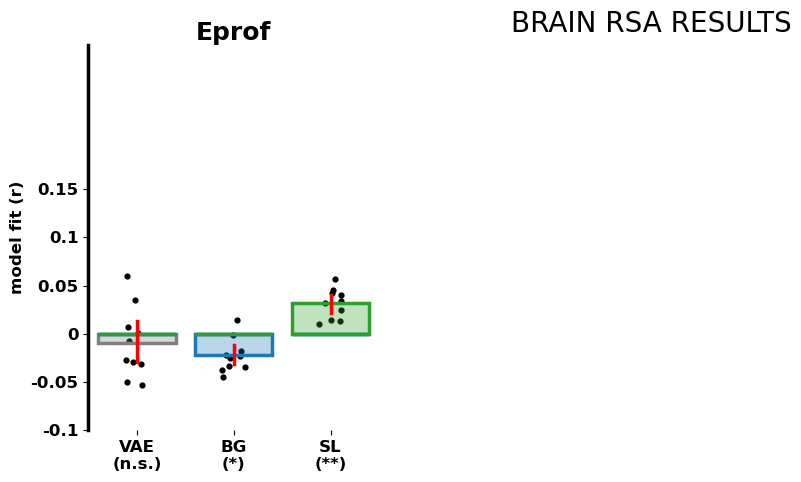

In [342]:
default_keys = ['Eprof']
scales_ = ['ratio']

model_rdms = dict()
model_idxs = dict()
for i in range(len(default_keys)):
    print(default_keys[i])
    inVec = df_matched[df_matched['bilingualism'].values==1.0][default_keys[i]].to_numpy()
    idx_bi = df_matched[df_matched['bilingualism'].values==1.0]['index'].to_numpy() 
    idx = idx_bi[~pd.isna(inVec)]
    inVec = inVec[~pd.isna(inVec)]
    print(len(idx))
    this_rdm = make_RDM(inVec, data_scale=scales_[i])
#     print(len(idx))
    model_rdms.update({default_keys[i] : this_rdm})
    model_idxs.update({default_keys[i] : idx})

data = [cmat_vae_vec_BRAIN, cmat_background_vec_BRAIN, cmat_salient_vec_BRAIN]

rsa_results = dict()
for key in default_keys:
    print(key)
    res = np.array([fit_rsa(datum, key, model_rdms, model_idxs) for datum in data]).transpose()
    rsa_results.update({key : res})

keys = default_keys
titles = default_keys

ncols = 3
nrows = int(np.ceil(len(keys)/2))

plt.figure(figsize=np.array((ncols,nrows))*5)

for i, key in enumerate(keys):
    ax = plt.subplot(nrows, ncols, i + 1)
    plot_nice_bar(key, rsa_results,
                  ax=ax, figsize=None,
                  dpi=300, fontsize=12,
                  fontsize_star=12,
                  fontweight='bold',
                  line_width=2.5,
                  marker_size=12, title=titles[i])
    ax.set_ylim(top=0.3) 
    
plt.subplots_adjust(
    left=None,
    bottom=None,
    right=None,
    top=None,
    wspace=.5,
    hspace=.5)

plt.suptitle('BRAIN RSA RESULTS',fontsize=20,y=.95);

#### why age is not good?

=== AGE DISTRIBUTION IN BILINGUAL SAMPLE ===
Descriptive statistics:
count    215.000000
mean      23.172093
std        4.578818
min       18.000000
25%       20.000000
50%       22.000000
75%       25.000000
max       40.000000
Name: age, dtype: float64

Missing values: 0

Bilingual sample (n=215):
  Age: mean=23.17, std=4.58
  Range: 18.0 - 40.0


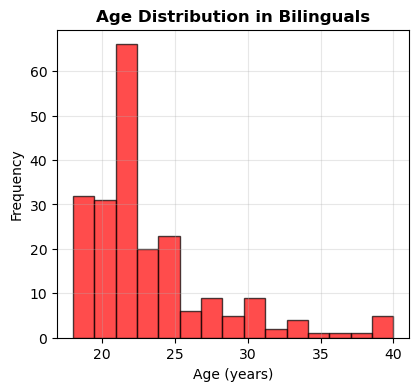

In [522]:
# Get only bilingual subjects
df_bi = df_sort[df_sort['bilingualism'] == 1]

print("=== AGE DISTRIBUTION IN BILINGUAL SAMPLE ===")
print("Descriptive statistics:")
print(df_bi['age'].describe())
print(f"\nMissing values: {df_bi['age'].isna().sum()}")

# Visualize age distribution in bilinguals only
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
df_bi['age'].hist(bins=15, alpha=0.7, color='red', edgecolor='black')
plt.title('Age Distribution in Bilinguals', fontweight='bold')
plt.xlabel('Age (years)')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)

print(f"\nBilingual sample (n={len(df_bi['age'].dropna())}):")
print(f"  Age: mean={df_bi['age'].mean():.2f}, std={df_bi['age'].std():.2f}")
print(f"  Range: {df_bi['age'].min():.1f} - {df_bi['age'].max():.1f}")

Starting with 215 bilinguals with age data

Original age distribution:
Bin 0 (18.0-22.4 years): 129 subjects
Bin 1 (22.4-26.8 years): 49 subjects
Bin 2 (26.8-31.2 years): 23 subjects
Bin 3 (31.2-35.6 years): 7 subjects
Bin 4 (35.6-40.0 years): 7 subjects

Target per age bin: 7 subjects

Age-uniform sample: 35 subjects


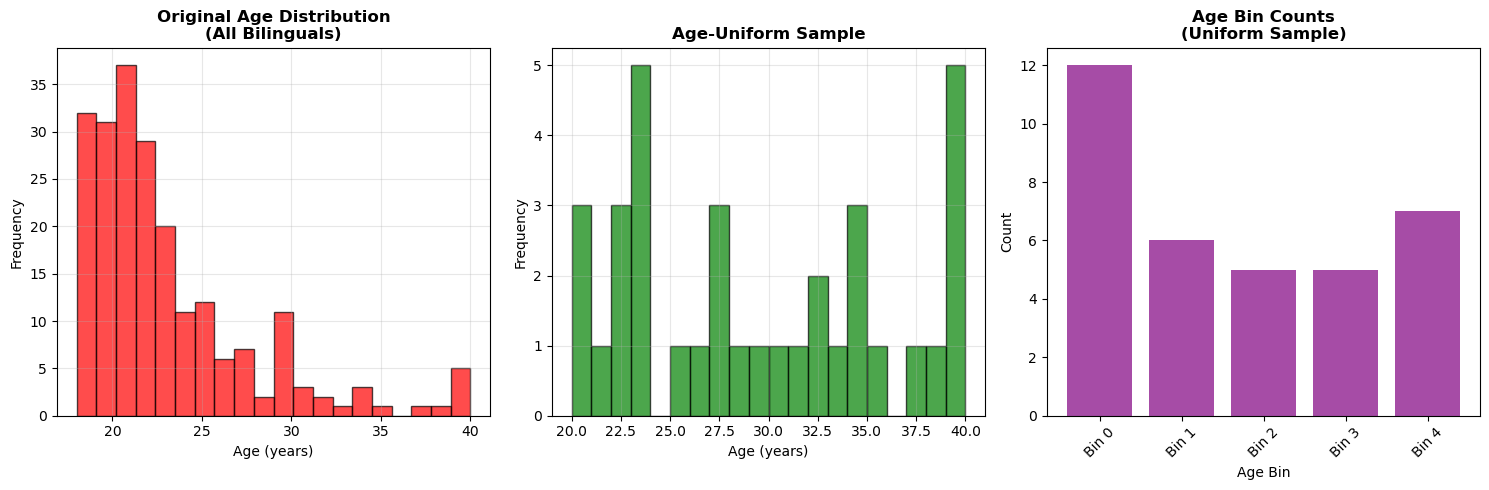


=== FINAL SAMPLE STATISTICS ===
Sample size: 35
Age: mean=29.06, std=6.62
Age range: 20.0 - 40.0

Age uniformity across 5 bins:
  Bin 0 (18.0-22.4 years): 12 subjects
  Bin 1 (22.4-26.8 years): 6 subjects
  Bin 2 (26.8-31.2 years): 5 subjects
  Bin 3 (31.2-35.6 years): 5 subjects
  Bin 4 (35.6-40.0 years): 7 subjects

Dataset ready for RSA with 35 subjects


In [523]:
# Get bilinguals with age data
df_bi_clean = df_sort[(df_sort['bilingualism'] == 1) & 
                      df_sort['age'].notna()].copy()

print(f"Starting with {len(df_bi_clean)} bilinguals with age data")

# Create age bins for uniform sampling
n_age_bins = 5  # Adjust this for more/fewer age groups
age_bins = pd.cut(df_bi_clean['age'], bins=n_age_bins, labels=False)
age_bin_counts = pd.Series(age_bins).value_counts().sort_index()

print("\nOriginal age distribution:")
bin_edges = pd.cut(df_bi_clean['age'], bins=n_age_bins).cat.categories
for i, count in enumerate(age_bin_counts):
    print(f"Bin {i} ({bin_edges[i].left:.1f}-{bin_edges[i].right:.1f} years): {count} subjects")

# Target: uniform distribution across age bins
min_count = min(age_bin_counts[age_bin_counts > 0])  # Use smallest non-zero bin
target_per_bin = min_count
print(f"\nTarget per age bin: {target_per_bin} subjects")

# Sample uniformly across age bins
uniform_age_indices = []

for bin_idx in range(n_age_bins):
    bin_mask = (age_bins == bin_idx)
    bin_subjects = df_bi_clean[bin_mask].index.values
    
    if len(bin_subjects) >= target_per_bin:
        # Randomly sample target_per_bin subjects from this age bin
        selected = np.random.choice(bin_subjects, size=target_per_bin, replace=False)
        uniform_age_indices.extend(selected)
    elif len(bin_subjects) > 0:
        # Take all available subjects if fewer than target
        uniform_age_indices.extend(bin_subjects)

# Create age-uniform dataset
df_age_uniform = df_sort.loc[uniform_age_indices].copy()

print(f"\nAge-uniform sample: {len(df_age_uniform)} subjects")

# Visualize results
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
df_bi_clean['age'].hist(bins=20, alpha=0.7, color='red', edgecolor='black')
plt.title('Original Age Distribution\n(All Bilinguals)', fontweight='bold')
plt.xlabel('Age (years)')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)

plt.subplot(1, 3, 2)
df_age_uniform['age'].hist(bins=20, alpha=0.7, color='green', edgecolor='black')
plt.title('Age-Uniform Sample', fontweight='bold')
plt.xlabel('Age (years)')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)

plt.subplot(1, 3, 3)
# Age uniformity check - bar plot of bin counts
final_age_bins = pd.cut(df_age_uniform['age'], bins=n_age_bins, labels=False)
final_age_counts = pd.Series(final_age_bins).value_counts().sort_index()
plt.bar(range(len(final_age_counts)), final_age_counts.values, alpha=0.7, color='purple')
plt.title('Age Bin Counts\n(Uniform Sample)', fontweight='bold')
plt.xlabel('Age Bin')
plt.ylabel('Count')
plt.xticks(range(len(final_age_counts)), [f'Bin {i}' for i in range(len(final_age_counts))], rotation=45)

plt.tight_layout()
plt.show()

# Print final statistics
print(f"\n=== FINAL SAMPLE STATISTICS ===")
print(f"Sample size: {len(df_age_uniform)}")
print(f"Age: mean={df_age_uniform['age'].mean():.2f}, std={df_age_uniform['age'].std():.2f}")
print(f"Age range: {df_age_uniform['age'].min():.1f} - {df_age_uniform['age'].max():.1f}")
print(f"\nAge uniformity across {n_age_bins} bins:")
for i, count in enumerate(final_age_counts):
    bin_range = bin_edges[i]
    print(f"  Bin {i} ({bin_range.left:.1f}-{bin_range.right:.1f} years): {count} subjects")

# Set this as the matched dataset for RSA analysis
df_matched = df_age_uniform.copy()
print(f"\nDataset ready for RSA with {len(df_matched)} subjects")

age
35
age


/tmp/ipykernel_1102596/448887420.py:142: DeprecationWarning: Please import `kendalltau` from the `scipy.stats` namespace; the `scipy.stats.stats` namespace is deprecated and will be removed in SciPy 2.0.0.
  corr = scipy.stats.stats.kendalltau
/tmp/ipykernel_1102596/448887420.py:51: FutureWarning: 

The `errcolor` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'color': 'r'}` instead.

  b = sns.barplot(data=plot_data,errcolor='r',linewidth=line_width,errwidth=line_width,facecolor=np.hstack((np.array(pallete_new[i]),.3)),edgecolor=np.hstack((np.array(pallete_new[i]),1)))
/tmp/ipykernel_1102596/448887420.py:51: FutureWarning: 

The `errwidth` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'linewidth': 2.5}` instead.

  b = sns.barplot(data=plot_data,errcolor='r',linewidth=line_width,errwidth=line_width,facecolor=np.hstack((np.array(pallete_new[i]),.3)),edgecolor=np.hstack((np.array(pallete_new[i]),1)))
/tmp/ipykernel_1102596/448887420.py:

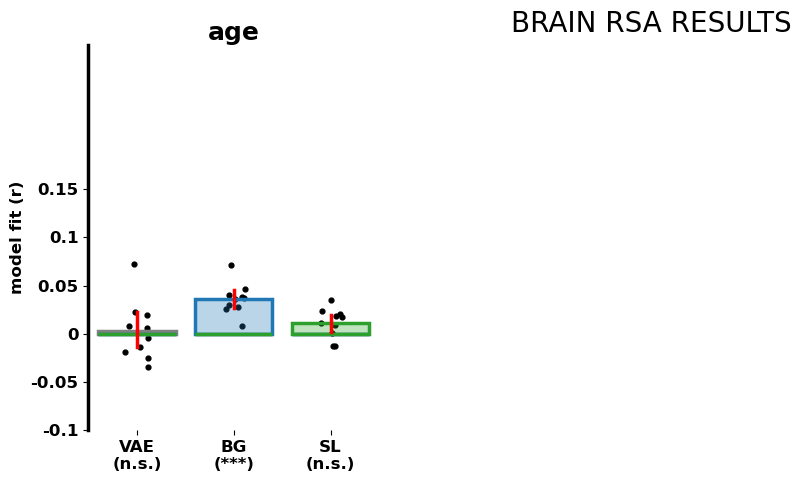

In [524]:
default_keys = ['age']
scales_ = ['ratio']

model_rdms = dict()
model_idxs = dict()
for i in range(len(default_keys)):
    print(default_keys[i])
    inVec = df_matched[df_matched['bilingualism'].values==1.0][default_keys[i]].to_numpy()
    idx_bi = df_matched[df_matched['bilingualism'].values==1.0]['index'].to_numpy() 
    idx = idx_bi[~pd.isna(inVec)]
    inVec = inVec[~pd.isna(inVec)]
    print(len(idx))
    this_rdm = make_RDM(inVec, data_scale=scales_[i])
#     print(len(idx))
    model_rdms.update({default_keys[i] : this_rdm})
    model_idxs.update({default_keys[i] : idx})

data = [cmat_vae_vec_BRAIN, cmat_background_vec_BRAIN, cmat_salient_vec_BRAIN]

rsa_results = dict()
for key in default_keys:
    print(key)
    res = np.array([fit_rsa(datum, key, model_rdms, model_idxs) for datum in data]).transpose()
    rsa_results.update({key : res})

keys = default_keys
titles = default_keys

ncols = 3
nrows = int(np.ceil(len(keys)/2))

plt.figure(figsize=np.array((ncols,nrows))*5)

for i, key in enumerate(keys):
    ax = plt.subplot(nrows, ncols, i + 1)
    plot_nice_bar(key, rsa_results,
                  ax=ax, figsize=None,
                  dpi=300, fontsize=12,
                  fontsize_star=12,
                  fontweight='bold',
                  line_width=2.5,
                  marker_size=12, title=titles[i])
    ax.set_ylim(top=0.3) 
    
plt.subplots_adjust(
    left=None,
    bottom=None,
    right=None,
    top=None,
    wspace=.5,
    hspace=.5)

plt.suptitle('BRAIN RSA RESULTS',fontsize=20,y=.95);

In [525]:
salient_sprof = rsa_results['age'][:,2]  # Salient model correlations
background_sprof = rsa_results['age'][:,1]  # Background model correlations

# Perform paired t-test
ttest_rel(salient_sprof, background_sprof)

NameError: name 'ttest_rel' is not defined

### get rsa results

In [40]:
default_keys = ['age', 'SES', 'sex', 'dominant_prof','non_dominant_prof', 'balance_index', 'aoa']
scales = ['ratio', 'ratio', 'ordinal', 'ratio','ratio', 'ratio', 'ratio']

model_rdms = dict()
model_idxs = dict()
for i in range(len(default_keys)):
    print(default_keys[i])
    inVec = df_sort[df_sort['bilingualism'].values==1.0][default_keys[i]].to_numpy()
    idx_bi = df_sort[df_sort['bilingualism'].values==1.0]['index'].to_numpy() 
    idx = idx_bi[~pd.isna(inVec)]
    inVec = inVec[~pd.isna(inVec)]
    print(len(idx))
    this_rdm = make_RDM(inVec, data_scale=scales[i])
#     print(len(idx))
    model_rdms.update({default_keys[i] : this_rdm})
    model_idxs.update({default_keys[i] : idx})

age
215
SES
178
sex
200
dominant_prof
215
non_dominant_prof
215
balance_index
215
aoa
215


In [41]:
data = [cmat_vae_vec_BRAIN, cmat_background_vec_BRAIN, cmat_salient_vec_BRAIN]

rsa_results = dict()
for key in default_keys:
    print(key)
    res = np.array([fit_rsa(datum, key, model_rdms, model_idxs) for datum in data]).transpose()
    rsa_results.update({key : res})

age
SES


/tmp/ipykernel_2423355/448887420.py:142: DeprecationWarning: Please import `kendalltau` from the `scipy.stats` namespace; the `scipy.stats.stats` namespace is deprecated and will be removed in SciPy 2.0.0.
  corr = scipy.stats.stats.kendalltau


sex
dominant_prof
non_dominant_prof
balance_index
aoa


In [64]:
var = 'age'
print(rsa_results[var][:,2].mean())
# print(rsa_results[var][:,1].mean() - rsa_results[var][:,2].mean())
import scipy.stats
scipy.stats.ttest_1samp(rsa_results[var][:,2],0)

# scipy.stats.ttest_rel(rsa_results[var][:,1], rsa_results[var][:,2])

0.012697801826982023


TtestResult(statistic=np.float64(5.51106920199938), pvalue=np.float64(0.0003747825683454081), df=np.int64(9))

/tmp/ipykernel_2423355/448887420.py:51: FutureWarning: 

The `errcolor` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'color': 'r'}` instead.

  b = sns.barplot(data=plot_data,errcolor='r',linewidth=line_width,errwidth=line_width,facecolor=np.hstack((np.array(pallete_new[i]),.3)),edgecolor=np.hstack((np.array(pallete_new[i]),1)))
/tmp/ipykernel_2423355/448887420.py:51: FutureWarning: 

The `errwidth` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'linewidth': 2.5}` instead.

  b = sns.barplot(data=plot_data,errcolor='r',linewidth=line_width,errwidth=line_width,facecolor=np.hstack((np.array(pallete_new[i]),.3)),edgecolor=np.hstack((np.array(pallete_new[i]),1)))
/tmp/ipykernel_2423355/448887420.py:51: FutureWarning: 

The `errcolor` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'color': 'r'}` instead.

  b = sns.barplot(data=plot_data,errcolor='r',linewidth=line_width,errwidth=line_width,facecolor=np.hstack((np.

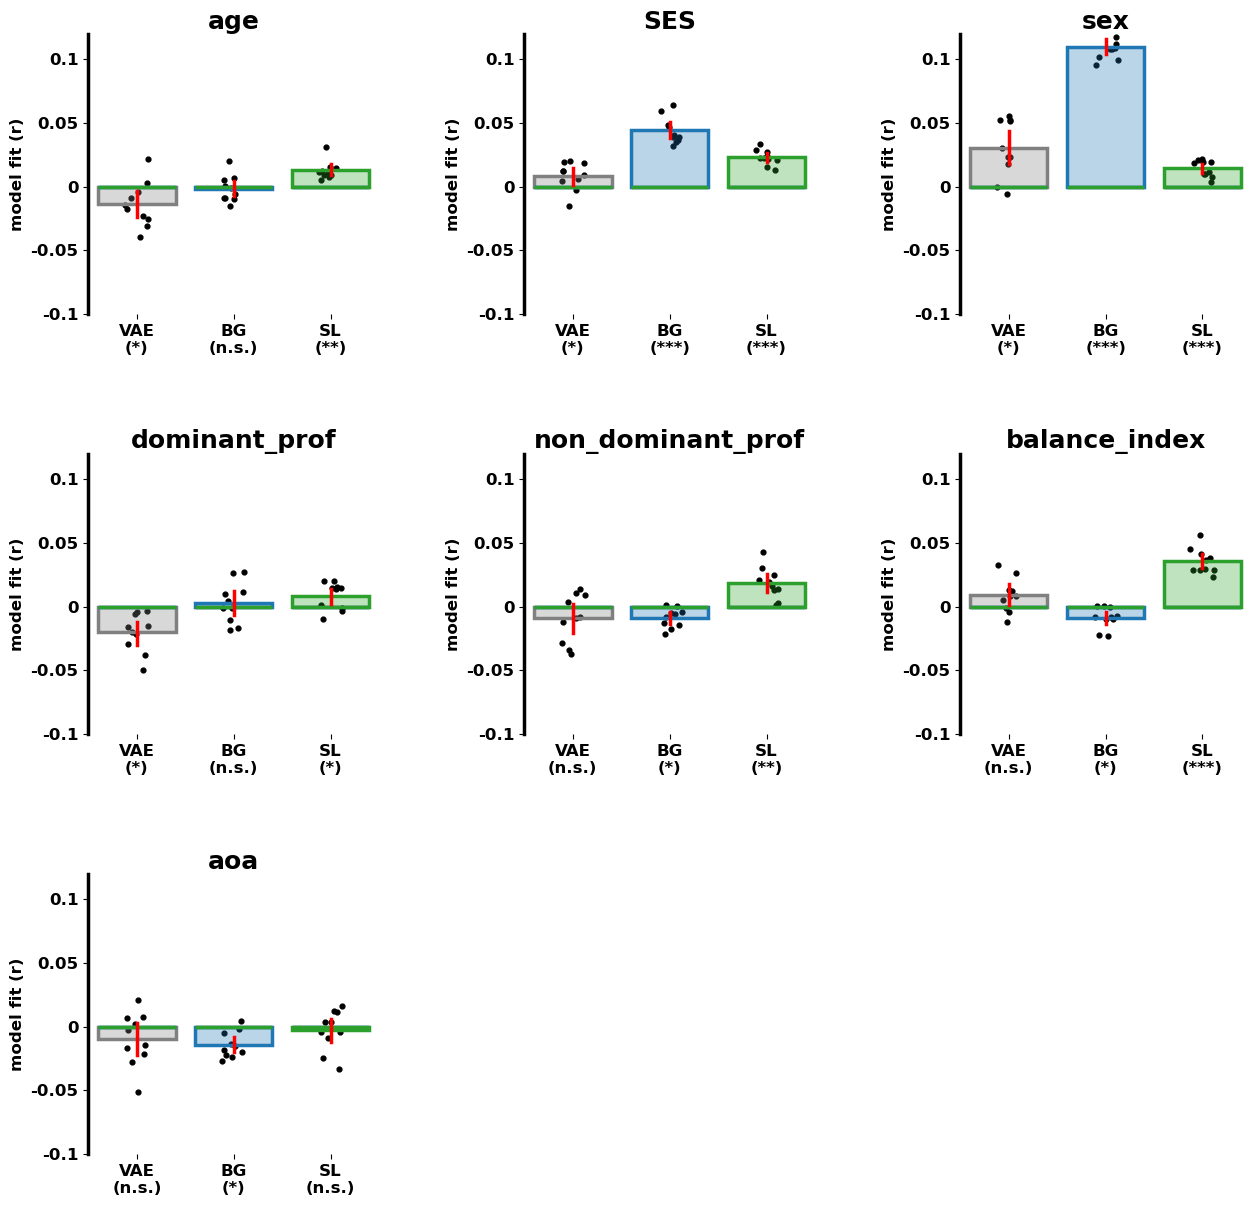

In [42]:
keys = default_keys
titles = default_keys

ncols = 3
nrows = int(np.ceil(len(keys)/2))

plt.figure(figsize=np.array((ncols,nrows))*5)

for i, key in enumerate(keys):
    ax = plt.subplot(nrows, ncols, i + 1)
    plot_nice_bar(key, rsa_results,
                  ax=ax, figsize=None,
                  dpi=300, fontsize=12,
                  fontsize_star=12,
                  fontweight='bold',
                  line_width=2.5,
                  marker_size=12, title=titles[i])
    ax.set_ylim(top=0.12) 
    
plt.subplots_adjust(
    left=None,
    bottom=None,
    right=None,
    top=None,
    wspace=.5,
    hspace=.5)

# plt.suptitle('BRAIN RSA RESULTS',fontsize=20,y=.95);

### resample all variables

In [65]:
def resample_distribution(df, variable, distribution='uniform', n_bins=5, subjects_per_bin=None, 
                         bilingual_only=True, random_state=None, normal_std_factor=1.0, 
                         exclude_outliers=True, outlier_percentiles=(2.5, 97.5), debug=False,
                         bimodal_peaks=(0.25, 0.75), bimodal_ratio=0.8):
    """
    Resample data to create uniform, normal, or bimodal distribution for a given variable.
    
    Parameters:
    -----------
    df : pd.DataFrame
        Input dataframe
    variable : str
        Column name of the variable to make uniform/normal/bimodal
    distribution : str, default='uniform'
        Type of distribution to create: 'uniform', 'normal', or 'bimodal'
    n_bins : int, default=5
        Number of bins to divide the variable into
    subjects_per_bin : int, optional
        For uniform: Number of subjects per bin. If None, uses minimum non-zero bin count
        For normal: Maximum subjects per bin (center bins will have more subjects)
        For bimodal: Maximum subjects per peak bin
    bilingual_only : bool, default=True
        Whether to only consider bilingual subjects (bilingualism == 1)
    random_state : int, optional
        Random seed for reproducibility
    normal_std_factor : float, default=1.0
        Controls the spread of normal distribution (higher = more spread out)
    exclude_outliers : bool, default=True
        Whether to exclude outliers before resampling
    outlier_percentiles : tuple, default=(2.5, 97.5)
        Percentile range to keep (excludes values outside this range)
    bimodal_peaks : tuple, default=(0.25, 0.75)
        Relative positions of the two peaks (0.0 to 1.0)
    bimodal_ratio : float, default=0.8
        Ratio of subjects in peak bins vs valley bins (0.0 to 1.0)
        
    Returns:
    --------
    list
        List of indices from original dataframe for the resampled subjects
    """
    
    if random_state is not None:
        np.random.seed(random_state)
    
    # Filter data
    if bilingual_only:
        df_clean = df[(df['bilingualism'] == 1) & df[variable].notna()].copy()
    else:
        df_clean = df[df[variable].notna()].copy()
    
    if debug:
        print(f"=== RESAMPLING {variable.upper()} for {distribution.upper()} DISTRIBUTION ===")
        print(f"Starting with {len(df_clean)} subjects with {variable} data")
    
    # Exclude outliers if requested
    if exclude_outliers:
        lower_bound = np.percentile(df_clean[variable], outlier_percentiles[0])
        upper_bound = np.percentile(df_clean[variable], outlier_percentiles[1])
        
        if debug:
            print(f"Excluding outliers: keeping {outlier_percentiles[0]}% to {outlier_percentiles[1]}% range")
            print(f"Value range: {lower_bound:.2f} to {upper_bound:.2f}")
        
        # Filter out outliers
        outlier_mask = (df_clean[variable] >= lower_bound) & (df_clean[variable] <= upper_bound)
        n_excluded = len(df_clean) - outlier_mask.sum()
        
        df_clean = df_clean[outlier_mask].copy()
        if debug:
            print(f"Excluded {n_excluded} outliers, remaining: {len(df_clean)} subjects")
    
    # Create bins for the variable
    var_bins = pd.cut(df_clean[variable], bins=n_bins, labels=False)
    bin_counts = pd.Series(var_bins).value_counts().sort_index()
    if debug:
        print(f"Bin counts: {bin_counts.values}")
    
    # Show original distribution
    if debug:
        print(f"\nOriginal {variable} distribution (after outlier removal):")
    bin_edges = pd.cut(df_clean[variable], bins=n_bins).cat.categories
    if debug:
        for i, count in enumerate(bin_counts):
            if i < len(bin_edges):
                print(f"Bin {i} ({bin_edges[i].left:.2f}-{bin_edges[i].right:.2f}): {count} subjects")
        
    # Determine target distribution
    if distribution == 'uniform':
        # Uniform: equal subjects per bin
        if subjects_per_bin is None:
            min_count = min(bin_counts[bin_counts > 0])
            target_per_bin = min_count
        else:
            target_per_bin = subjects_per_bin
        
        target_counts = [target_per_bin] * n_bins
        if debug:
            print(f"\nTarget per bin (uniform): {target_per_bin} subjects")
        
    elif distribution == 'normal':
        # Normal: bell curve distribution
        if subjects_per_bin is None:
            max_subjects = min(bin_counts[bin_counts > 0])
        else:
            max_subjects = subjects_per_bin
            
        # Create normal distribution weights (bell curve)
        bin_centers = np.arange(n_bins)
        center_bin = (n_bins - 1) / 2
        
        # Calculate normal weights
        normal_weights = np.exp(-0.5 * ((bin_centers - center_bin) / (normal_std_factor * n_bins/6))**2)
        normal_weights = normal_weights / np.max(normal_weights)  # Normalize to max = 1
        
        # Scale to desired maximum
        target_counts = (normal_weights * max_subjects).astype(int)
        target_counts = np.maximum(target_counts, 1)  # Ensure at least 1 subject per bin
        
        if debug:
            print(f"\nTarget per bin (normal, max={max_subjects}):")
            for i, count in enumerate(target_counts):
                print(f"  Bin {i}: {count} subjects (weight={normal_weights[i]:.2f})")
    
    elif distribution == 'bimodal':
        # Bimodal: two peaks with valley in between
        if subjects_per_bin is None:
            max_subjects = min(bin_counts[bin_counts > 0])
        else:
            max_subjects = subjects_per_bin
            
        # Calculate peak positions in bin indices
        peak1_bin = int(bimodal_peaks[0] * (n_bins - 1))
        peak2_bin = int(bimodal_peaks[1] * (n_bins - 1))
        
        # Create bimodal weights
        bimodal_weights = np.full(n_bins, bimodal_ratio)  # Valley level
        
        # Create gaussian-like peaks around the specified positions
        sigma = n_bins / 8  # Width of each peak
        bin_centers = np.arange(n_bins)
        
        # Add first peak
        peak1_weights = np.exp(-0.5 * ((bin_centers - peak1_bin) / sigma)**2)
        peak1_weights = peak1_weights / np.max(peak1_weights)
        
        # Add second peak
        peak2_weights = np.exp(-0.5 * ((bin_centers - peak2_bin) / sigma)**2)
        peak2_weights = peak2_weights / np.max(peak2_weights)
        
        # Combine peaks (take maximum to avoid double-counting overlap)
        peak_weights = np.maximum(peak1_weights, peak2_weights)
        
        # Final weights: valley + peaks
        bimodal_weights = bimodal_ratio + (1 - bimodal_ratio) * peak_weights
        
        # Scale to desired maximum
        target_counts = (bimodal_weights * max_subjects).astype(int)
        target_counts = np.maximum(target_counts, 1)  # Ensure at least 1 subject per bin
        
        if debug:
            print(f"\nTarget per bin (bimodal, max={max_subjects}):")
            print(f"Peak positions: bin {peak1_bin} and bin {peak2_bin}")
            print(f"Valley ratio: {bimodal_ratio:.2f}")
            for i, count in enumerate(target_counts):
                peak_type = ""
                if i == peak1_bin or i == peak2_bin:
                    peak_type = " (PEAK)"
                elif bimodal_weights[i] <= bimodal_ratio + 0.1:
                    peak_type = " (valley)"
                print(f"  Bin {i}: {count} subjects (weight={bimodal_weights[i]:.2f}){peak_type}")
    
    else:
        raise ValueError("distribution must be 'uniform', 'normal', or 'bimodal'")
    
    # Sample according to target distribution
    resampled_indices = []
    
    for bin_idx in range(n_bins):
        target_count = target_counts[bin_idx]
        bin_mask = (var_bins == bin_idx)
        bin_subjects = df_clean[bin_mask].index.values
        
        if len(bin_subjects) >= target_count:
            # Randomly sample target_count subjects from this bin
            selected = np.random.choice(bin_subjects, size=target_count, replace=False)
            resampled_indices.extend(selected)
            if debug:
                print(f"Bin {bin_idx}: sampled {target_count}/{len(bin_subjects)} subjects")
        elif len(bin_subjects) > 0:
            # Take all available subjects if fewer than target
            resampled_indices.extend(bin_subjects)
            if debug:
                print(f"Bin {bin_idx}: took all {len(bin_subjects)} subjects (fewer than target)")
        else:
            if debug:
                print(f"Bin {bin_idx}: no subjects available")

    total_expected = sum(target_counts)
    if debug:
        print(f"\nFinal {distribution} sample: {len(resampled_indices)} subjects")
        print(f"Expected: {total_expected} subjects")
    
    return resampled_indices

#### uniform

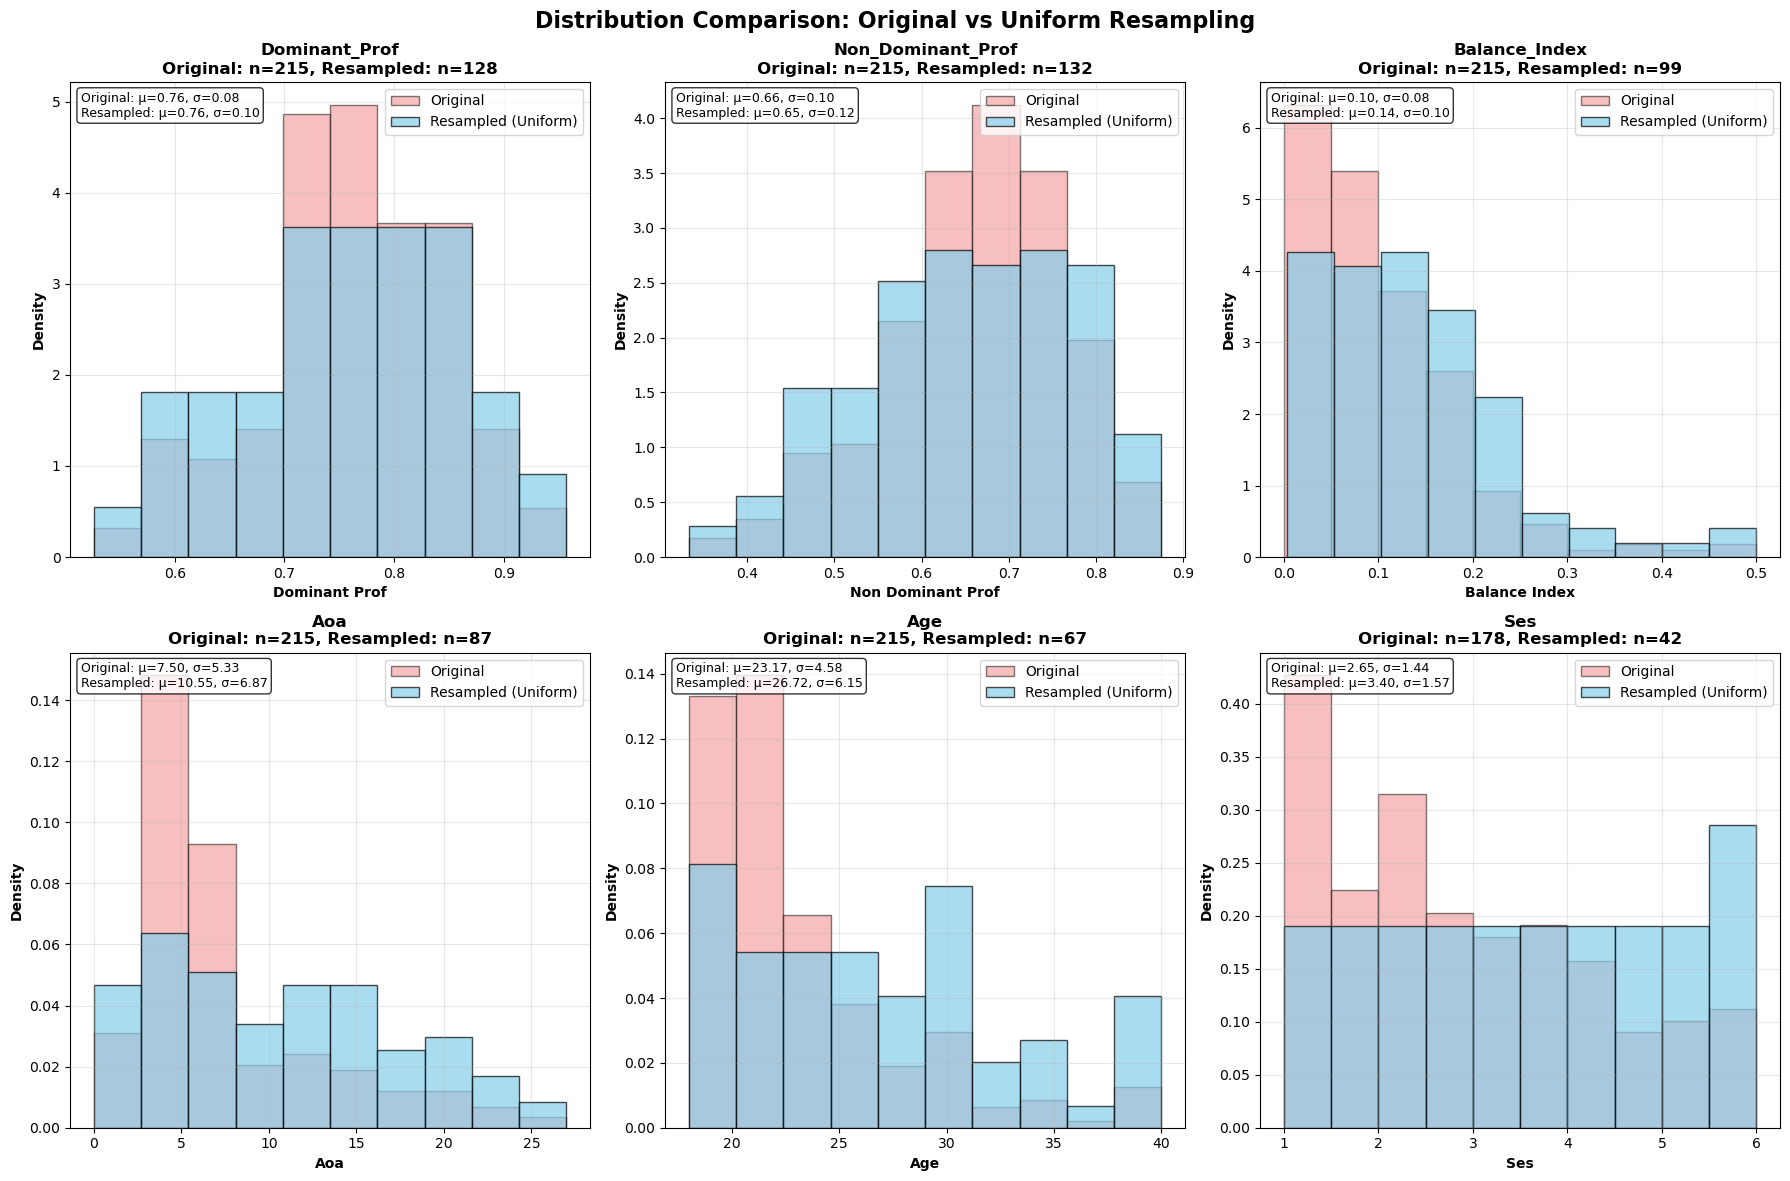


RESAMPLING SUMMARY
         Variable  Original_N  Resampled_N Original_Mean Resampled_Mean Original_Std Resampled_Std Reduction_%
    dominant_prof         215          128          0.76           0.76         0.08          0.10       40.5%
non_dominant_prof         215          132          0.66           0.65         0.10          0.12       38.6%
    balance_index         215           99          0.10           0.14         0.08          0.10       54.0%
              aoa         215           87          7.50          10.55         5.33          6.87       59.5%
              age         215           67         23.17          26.72         4.58          6.15       68.8%
              SES         178           42          2.65           3.40         1.44          1.57       76.4%


In [ ]:
default_keys = ['dominant_prof', 'non_dominant_prof', 'balance_index', 'aoa', 'age', 'SES']
scales_ = ['ratio', 'ratio', 'ratio', 'ratio', 'ratio', 'ratio']
# Store all resampled data for comparison
resampled_data = {}
original_data = {}
idx_dic = {}
# First, collect all the data
for key in default_keys:
    # Store original data
    original_data[key] = df_sort[df_sort['bilingualism'] == 1][key].dropna()
    
    # Resample
    indx = resample_distribution(df_sort, key, distribution='uniform', n_bins=50, subjects_per_bin=4, 
                               bilingual_only=True, random_state=42, 
                               exclude_outliers=False)
    idx_dic[key] = indx
    df_matched = df_sort.loc[indx].copy()
    resampled_data[key] = df_matched[df_matched['bilingualism'] == 1][key].dropna()

# Create comprehensive visualization
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

for i, key in enumerate(default_keys):
    ax = axes[i]
    
    # Plot original distribution
    ax.hist(original_data[key], bins=10, alpha=0.5, color='lightcoral', 
           edgecolor='black', label='Original', density=True)
    
    # Plot resampled distribution
    ax.hist(resampled_data[key], bins=10, alpha=0.7, color='skyblue', 
           edgecolor='black', label='Resampled (Uniform)', density=True)
    
    # Formatting
    ax.set_title(f'{key}\n'
                f'Original: n={len(original_data[key])}, '
                f'Resampled: n={len(resampled_data[key])}', 
                fontweight='bold', fontsize=12)
    ax.set_xlabel(key, fontweight='bold')
    ax.set_ylabel('Density', fontweight='bold')
    ax.legend(loc='upper right', fontsize=10)
    ax.grid(True, alpha=0.3)
    
    # Add statistics text
    orig_mean = original_data[key].mean()
    resamp_mean = resampled_data[key].mean()
    orig_std = original_data[key].std()
    resamp_std = resampled_data[key].std()
    
    stats_text = f'Original: μ={orig_mean:.2f}, σ={orig_std:.2f}\n' \
                f'Resampled: μ={resamp_mean:.2f}, σ={resamp_std:.2f}'
    
    ax.text(0.02, 0.98, stats_text, transform=ax.transAxes, 
           verticalalignment='top', fontsize=9, 
           bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.suptitle('Distribution Comparison: Original vs Uniform Resampling', 
            fontsize=16, fontweight='bold', y=0.98)
plt.tight_layout()
plt.subplots_adjust(top=0.92)
plt.show()

# Summary table
print("\n" + "="*80)
print("RESAMPLING SUMMARY")
print("="*80)
summary_table = []
for key in default_keys:
    summary_table.append({
        'Variable': key.title(),
        'Original_N': len(original_data[key]),
        'Resampled_N': len(resampled_data[key]),
        'Original_Mean': f"{original_data[key].mean():.2f}",
        'Resampled_Mean': f"{resampled_data[key].mean():.2f}",
        'Original_Std': f"{original_data[key].std():.2f}",
        'Resampled_Std': f"{resampled_data[key].std():.2f}",
        'Reduction_%': f"{(1 - len(resampled_data[key])/len(original_data[key]))*100:.1f}%"
    })

summary_df = pd.DataFrame(summary_table)
print(summary_df.to_string(index=False))

age
67
SES
42
aoa
87
dominant_prof
128
non_dominant_prof
132
balance_index
99
age
SES
aoa
dominant_prof
non_dominant_prof


/tmp/ipykernel_2423355/448887420.py:142: DeprecationWarning: Please import `kendalltau` from the `scipy.stats` namespace; the `scipy.stats.stats` namespace is deprecated and will be removed in SciPy 2.0.0.
  corr = scipy.stats.stats.kendalltau


balance_index


/tmp/ipykernel_2423355/448887420.py:51: FutureWarning: 

The `errcolor` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'color': 'r'}` instead.

  b = sns.barplot(data=plot_data,errcolor='r',linewidth=line_width,errwidth=line_width,facecolor=np.hstack((np.array(pallete_new[i]),.3)),edgecolor=np.hstack((np.array(pallete_new[i]),1)))
/tmp/ipykernel_2423355/448887420.py:51: FutureWarning: 

The `errwidth` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'linewidth': 2.5}` instead.

  b = sns.barplot(data=plot_data,errcolor='r',linewidth=line_width,errwidth=line_width,facecolor=np.hstack((np.array(pallete_new[i]),.3)),edgecolor=np.hstack((np.array(pallete_new[i]),1)))
/tmp/ipykernel_2423355/448887420.py:51: FutureWarning: 

The `errcolor` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'color': 'r'}` instead.

  b = sns.barplot(data=plot_data,errcolor='r',linewidth=line_width,errwidth=line_width,facecolor=np.hstack((np.

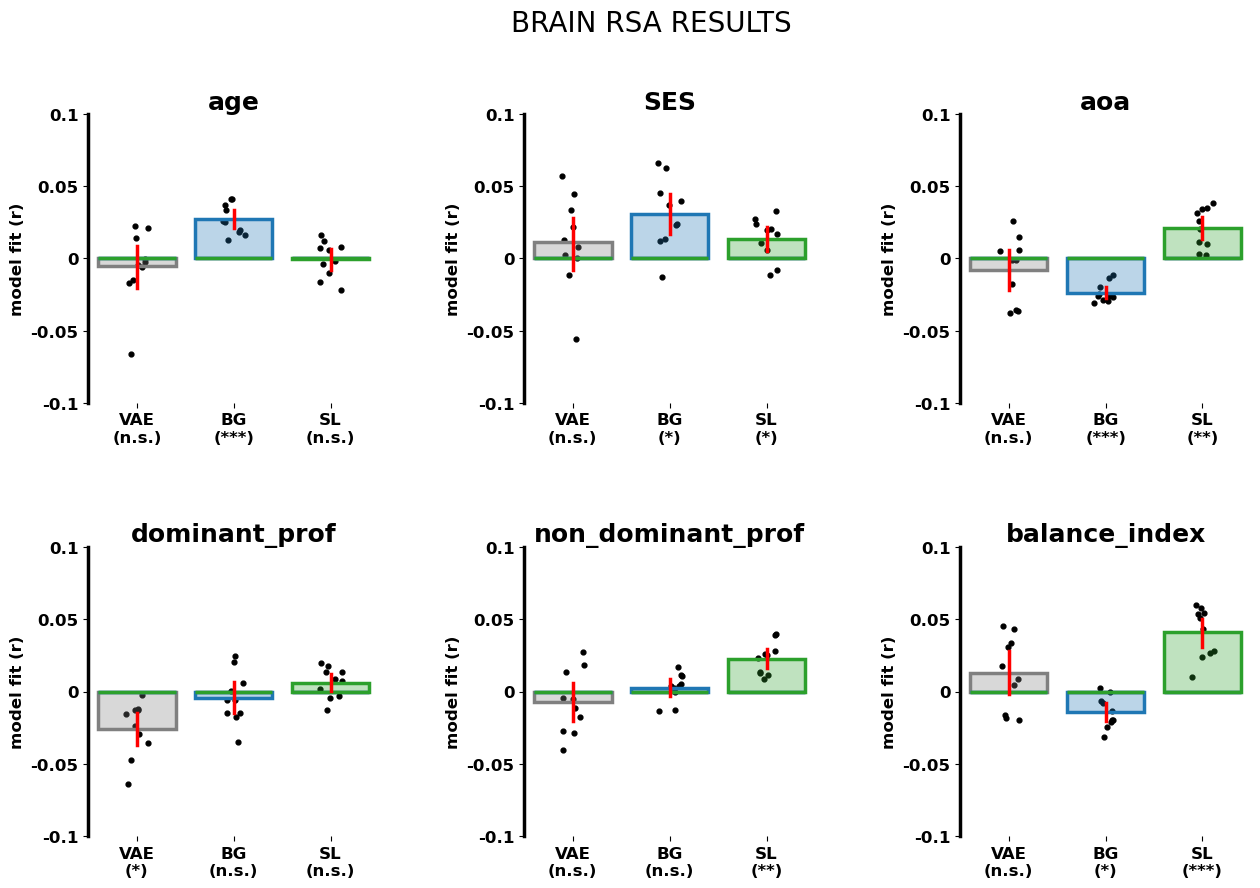

In [71]:
default_keys = ['age', 'SES', 'aoa', 'dominant_prof', 'non_dominant_prof', 'balance_index']
scales_ = ['ratio', 'ratio', 'ratio', 'ratio', 'ratio', 'ratio']
model_rdms = dict()
model_idxs = dict()
for i in range(len(default_keys)):
    print(default_keys[i])
    df_matched
    indx = idx_dic[default_keys[i]]
    inVec = df_sort.iloc[indx, :][default_keys[i]].to_numpy()
    idx = df_sort.iloc[indx, :]['index'].to_numpy()
    idx = idx[~pd.isna(inVec)]
    inVec = inVec[~pd.isna(inVec)]
    print(len(idx))
    this_rdm = make_RDM(inVec, data_scale=scales_[i])
#     print(len(idx))
    model_rdms.update({default_keys[i] : this_rdm})
    model_idxs.update({default_keys[i] : idx})

data = [cmat_vae_vec_BRAIN, cmat_background_vec_BRAIN, cmat_salient_vec_BRAIN]

rsa_results = dict()
for key in default_keys:
    print(key)
    res = np.array([fit_rsa(datum, key, model_rdms, model_idxs) for datum in data]).transpose()
    rsa_results.update({key : res})

keys = default_keys
titles = default_keys

ncols = 3
nrows = int(np.ceil(len(keys)/2))

plt.figure(figsize=np.array((ncols,nrows))*5)

for i, key in enumerate(keys):
    ax = plt.subplot(nrows, ncols, i + 1)
    plot_nice_bar(key, rsa_results,
                  ax=ax, figsize=None,
                  dpi=300, fontsize=12,
                  fontsize_star=12,
                  fontweight='bold',
                  line_width=2.5,
                  marker_size=12, title=titles[i])
    ax.set_ylim(top=0.1) 
    
plt.subplots_adjust(
    left=None,
    bottom=None,
    right=None,
    top=None,
    wspace=.5,
    hspace=.5)

plt.suptitle('BRAIN RSA RESULTS',fontsize=20,y=.95);

In [81]:
var = 'aoa'
# print(rsa_results[var][:,2].mean())
print(rsa_results[var][:,2].mean() - rsa_results[var][:,1].mean())
import scipy.stats
# scipy.stats.ttest_1samp(rsa_results[var][:,2],0)

scipy.stats.ttest_rel(rsa_results[var][:,2], rsa_results[var][:,1])

0.04495509256028532


TtestResult(statistic=np.float64(8.177093493868968), pvalue=np.float64(1.8574720410975627e-05), df=np.int64(9))

#### normal

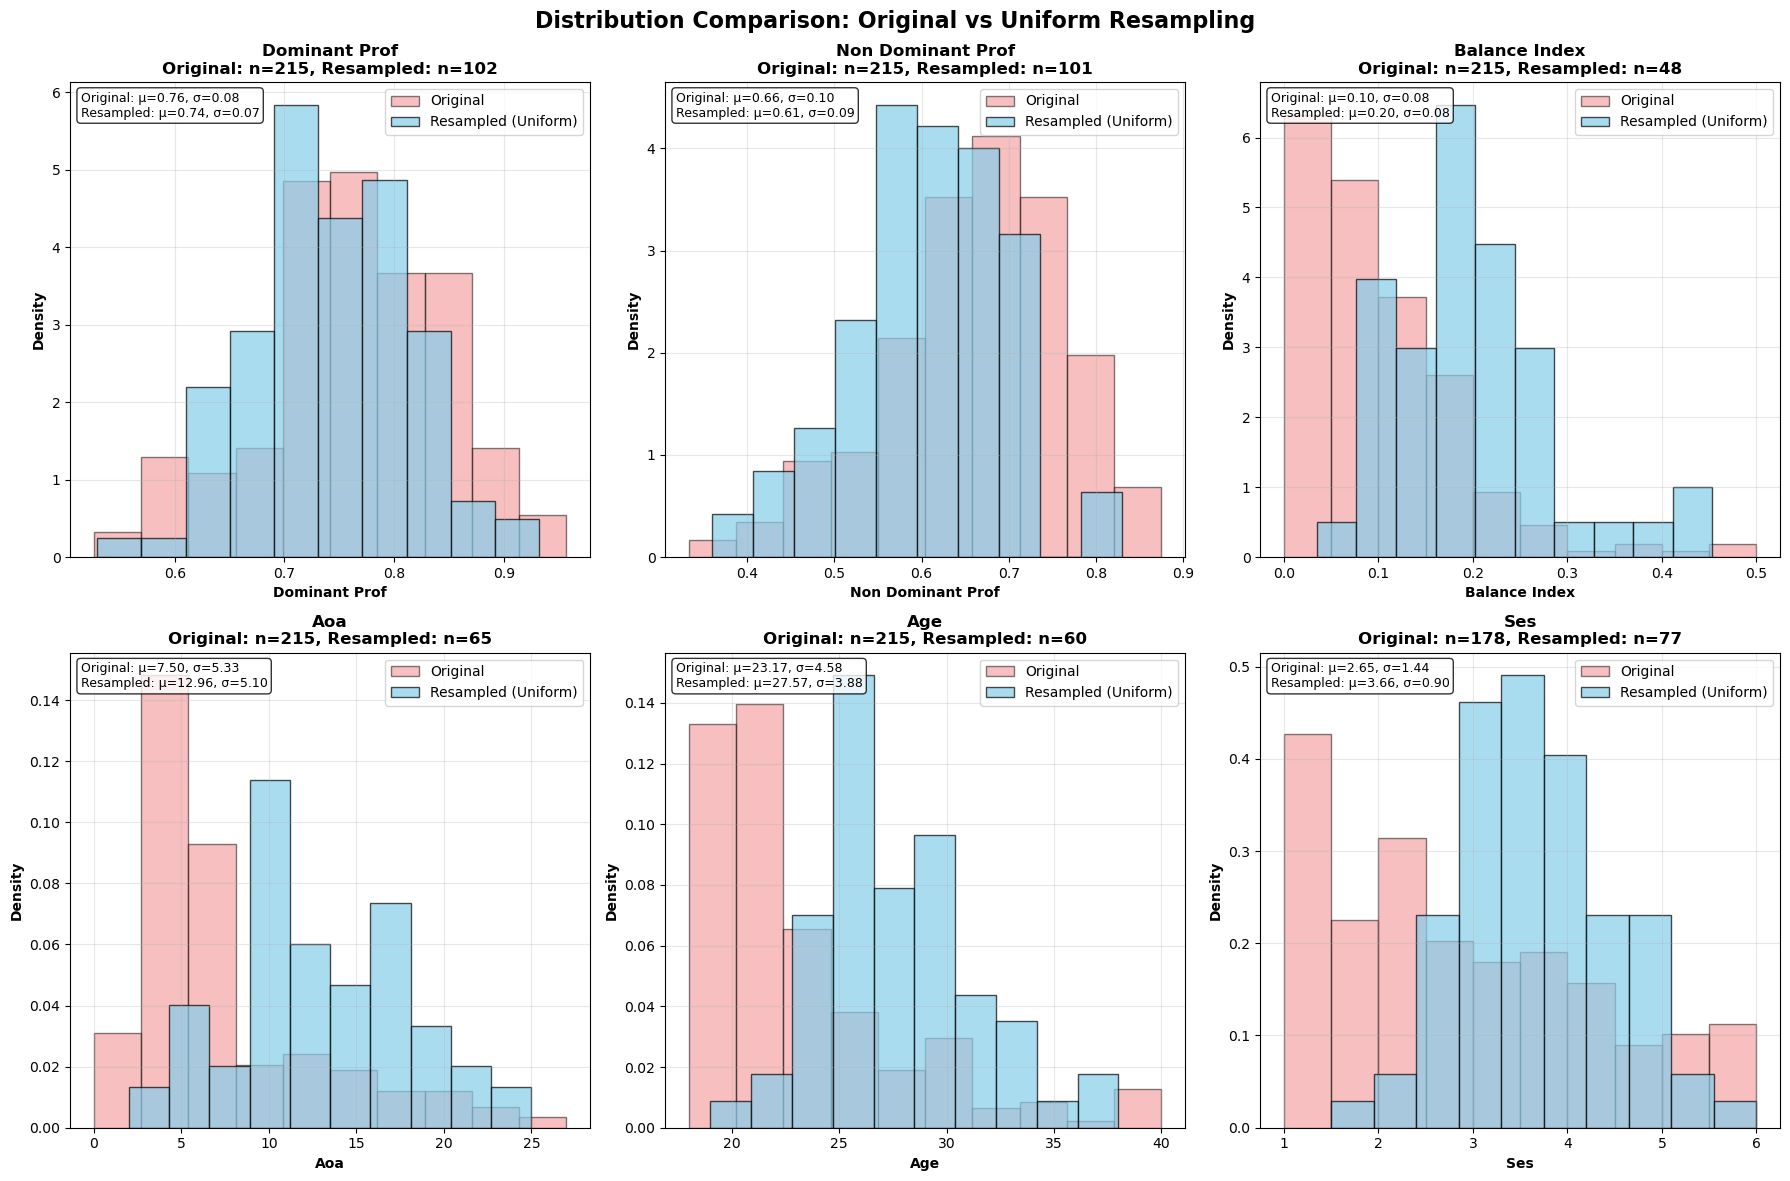


RESAMPLING SUMMARY
         Variable  Original_N  Resampled_N Original_Mean Resampled_Mean Original_Std Resampled_Std Reduction_%
    Dominant Prof         215          102          0.76           0.74         0.08          0.07       52.6%
Non Dominant Prof         215          101          0.66           0.61         0.10          0.09       53.0%
    Balance Index         215           48          0.10           0.20         0.08          0.08       77.7%
              Aoa         215           65          7.50          12.96         5.33          5.10       69.8%
              Age         215           60         23.17          27.57         4.58          3.88       72.1%
              Ses         178           77          2.65           3.66         1.44          0.90       56.7%


In [581]:
default_keys = ['dominant_prof', 'non_dominant_prof', 'balance_index', 'aoa', 'age', 'SES']
scales_ = ['ratio', 'ratio', 'ratio', 'ratio', 'ratio', 'ratio']
# Store all resampled data for comparison
resampled_data = {}
original_data = {}
idx_dic = {}
# First, collect all the data
for key in default_keys:
    # Store original data
    original_data[key] = df_sort[df_sort['bilingualism'] == 1][key].dropna()
    
    # Resample
    # Resample
    indx = resample_distribution(df_sort, key, 
                               distribution='normal',  # NEW: bimodal option
                               n_bins=10, 
                               subjects_per_bin=25, 
                               bilingual_only=True, 
                               random_state=42,
                               exclude_outliers=False, 
                            #    bimodal_peaks=(0.1, 0.9),  # Peaks at 10% and 90% positions
                            #    bimodal_ratio=0.2,         # Valley has only 20% of peak subjects
                               debug=False)
    idx_dic[key] = indx
    df_matched = df_sort.loc[indx].copy()
    resampled_data[key] = df_matched[df_matched['bilingualism'] == 1][key].dropna()

# Create comprehensive visualization
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

for i, key in enumerate(default_keys):
    ax = axes[i]
    
    # Plot original distribution
    ax.hist(original_data[key], bins=10, alpha=0.5, color='lightcoral', 
           edgecolor='black', label='Original', density=True)
    
    # Plot resampled distribution
    ax.hist(resampled_data[key], bins=10, alpha=0.7, color='skyblue', 
           edgecolor='black', label='Resampled (Uniform)', density=True)
    
    # Formatting
    ax.set_title(f'{key.replace("_", " ").title()}\n'
                f'Original: n={len(original_data[key])}, '
                f'Resampled: n={len(resampled_data[key])}', 
                fontweight='bold', fontsize=12)
    ax.set_xlabel(key.replace('_', ' ').title(), fontweight='bold')
    ax.set_ylabel('Density', fontweight='bold')
    ax.legend(loc='upper right', fontsize=10)
    ax.grid(True, alpha=0.3)
    
    # Add statistics text
    orig_mean = original_data[key].mean()
    resamp_mean = resampled_data[key].mean()
    orig_std = original_data[key].std()
    resamp_std = resampled_data[key].std()
    
    stats_text = f'Original: μ={orig_mean:.2f}, σ={orig_std:.2f}\n' \
                f'Resampled: μ={resamp_mean:.2f}, σ={resamp_std:.2f}'
    
    ax.text(0.02, 0.98, stats_text, transform=ax.transAxes, 
           verticalalignment='top', fontsize=9, 
           bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.suptitle('Distribution Comparison: Original vs Uniform Resampling', 
            fontsize=16, fontweight='bold', y=0.98)
plt.tight_layout()
plt.subplots_adjust(top=0.92)
plt.show()

# Summary table
print("\n" + "="*80)
print("RESAMPLING SUMMARY")
print("="*80)
summary_table = []
for key in default_keys:
    summary_table.append({
        'Variable': key.replace('_', ' ').title(),
        'Original_N': len(original_data[key]),
        'Resampled_N': len(resampled_data[key]),
        'Original_Mean': f"{original_data[key].mean():.2f}",
        'Resampled_Mean': f"{resampled_data[key].mean():.2f}",
        'Original_Std': f"{original_data[key].std():.2f}",
        'Resampled_Std': f"{resampled_data[key].std():.2f}",
        'Reduction_%': f"{(1 - len(resampled_data[key])/len(original_data[key]))*100:.1f}%"
    })

summary_df = pd.DataFrame(summary_table)
print(summary_df.to_string(index=False))

dominant_prof
102
non_dominant_prof
101
balance_index
48
aoa
65
age
60
SES
77
dominant_prof
non_dominant_prof
balance_index
aoa
age
SES


/tmp/ipykernel_1102596/448887420.py:142: DeprecationWarning: Please import `kendalltau` from the `scipy.stats` namespace; the `scipy.stats.stats` namespace is deprecated and will be removed in SciPy 2.0.0.
  corr = scipy.stats.stats.kendalltau
/tmp/ipykernel_1102596/448887420.py:51: FutureWarning: 

The `errcolor` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'color': 'r'}` instead.

  b = sns.barplot(data=plot_data,errcolor='r',linewidth=line_width,errwidth=line_width,facecolor=np.hstack((np.array(pallete_new[i]),.3)),edgecolor=np.hstack((np.array(pallete_new[i]),1)))
/tmp/ipykernel_1102596/448887420.py:51: FutureWarning: 

The `errwidth` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'linewidth': 2.5}` instead.

  b = sns.barplot(data=plot_data,errcolor='r',linewidth=line_width,errwidth=line_width,facecolor=np.hstack((np.array(pallete_new[i]),.3)),edgecolor=np.hstack((np.array(pallete_new[i]),1)))
/tmp/ipykernel_1102596/448887420.py:

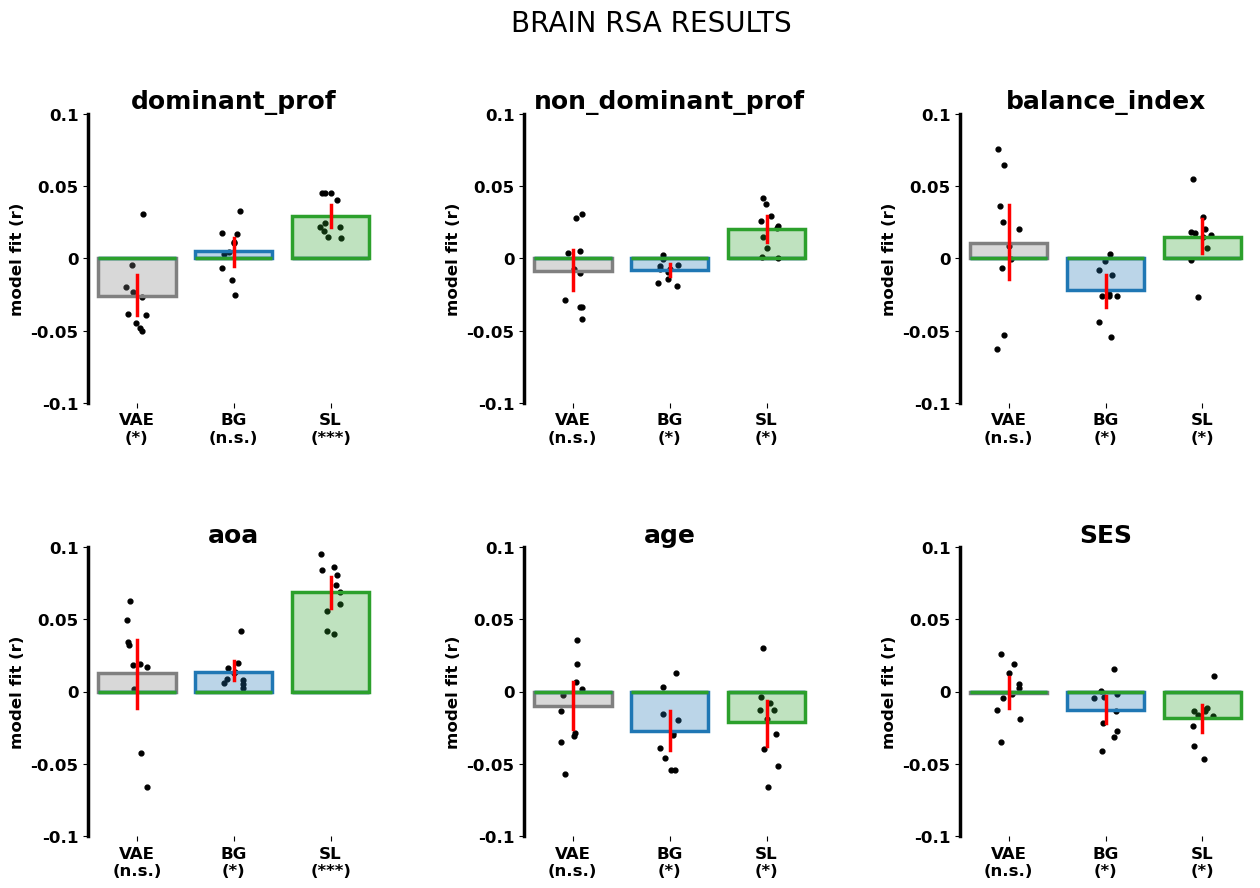

In [582]:
model_rdms = dict()
model_idxs = dict()
for i in range(len(default_keys)):
    print(default_keys[i])
    df_matched
    indx = idx_dic[default_keys[i]]
    inVec = df_sort.iloc[indx, :][default_keys[i]].to_numpy()
    idx = df_sort.iloc[indx, :]['index'].to_numpy()
    idx = idx[~pd.isna(inVec)]
    inVec = inVec[~pd.isna(inVec)]
    print(len(idx))
    this_rdm = make_RDM(inVec, data_scale=scales_[i])
#     print(len(idx))
    model_rdms.update({default_keys[i] : this_rdm})
    model_idxs.update({default_keys[i] : idx})

data = [cmat_vae_vec_BRAIN, cmat_background_vec_BRAIN, cmat_salient_vec_BRAIN]

rsa_results = dict()
for key in default_keys:
    print(key)
    res = np.array([fit_rsa(datum, key, model_rdms, model_idxs) for datum in data]).transpose()
    rsa_results.update({key : res})

keys = default_keys
titles = default_keys

ncols = 3
nrows = int(np.ceil(len(keys)/2))

plt.figure(figsize=np.array((ncols,nrows))*5)

for i, key in enumerate(keys):
    ax = plt.subplot(nrows, ncols, i + 1)
    plot_nice_bar(key, rsa_results,
                  ax=ax, figsize=None,
                  dpi=300, fontsize=12,
                  fontsize_star=12,
                  fontweight='bold',
                  line_width=2.5,
                  marker_size=12, title=titles[i])
    ax.set_ylim(top=0.1) 
    
plt.subplots_adjust(
    left=None,
    bottom=None,
    right=None,
    top=None,
    wspace=.5,
    hspace=.5)

plt.suptitle('BRAIN RSA RESULTS',fontsize=20,y=.95);